In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 200)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Import additional libraries
import datetime
from datetime import timedelta
from collections import defaultdict
from itertools import product
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

In [2]:
# Load the dataset
df = pd.read_excel('_data/_matches_list_v4.xlsx')

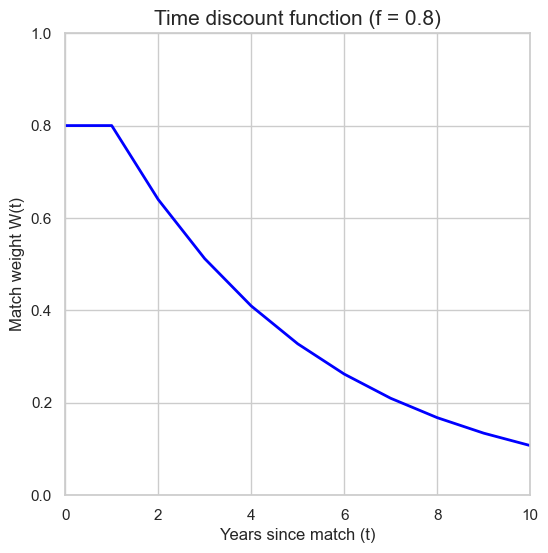

In [3]:
# Define the time discount function
def time_discount(t, f=0.8):
    return np.minimum(f**t, f)

# Create a range of years since the match
years_since_match = np.arange(0, 11, 1)  # 0 to 10 years

# Apply the time discount function to each year
weights = time_discount(years_since_match)

# Set the Seaborn theme for prettier plots
sns.set_theme(style="whitegrid")

# Plot the time discount function
plt.figure(figsize=(6, 6))
sns.lineplot(x=years_since_match, y=weights, color='blue', lw=2)
plt.title('Time discount function (f = 0.8)', fontsize=15)
plt.xlabel('Years since match (t)', fontsize=12)
plt.ylabel('Match weight W(t)', fontsize=12)
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.show()


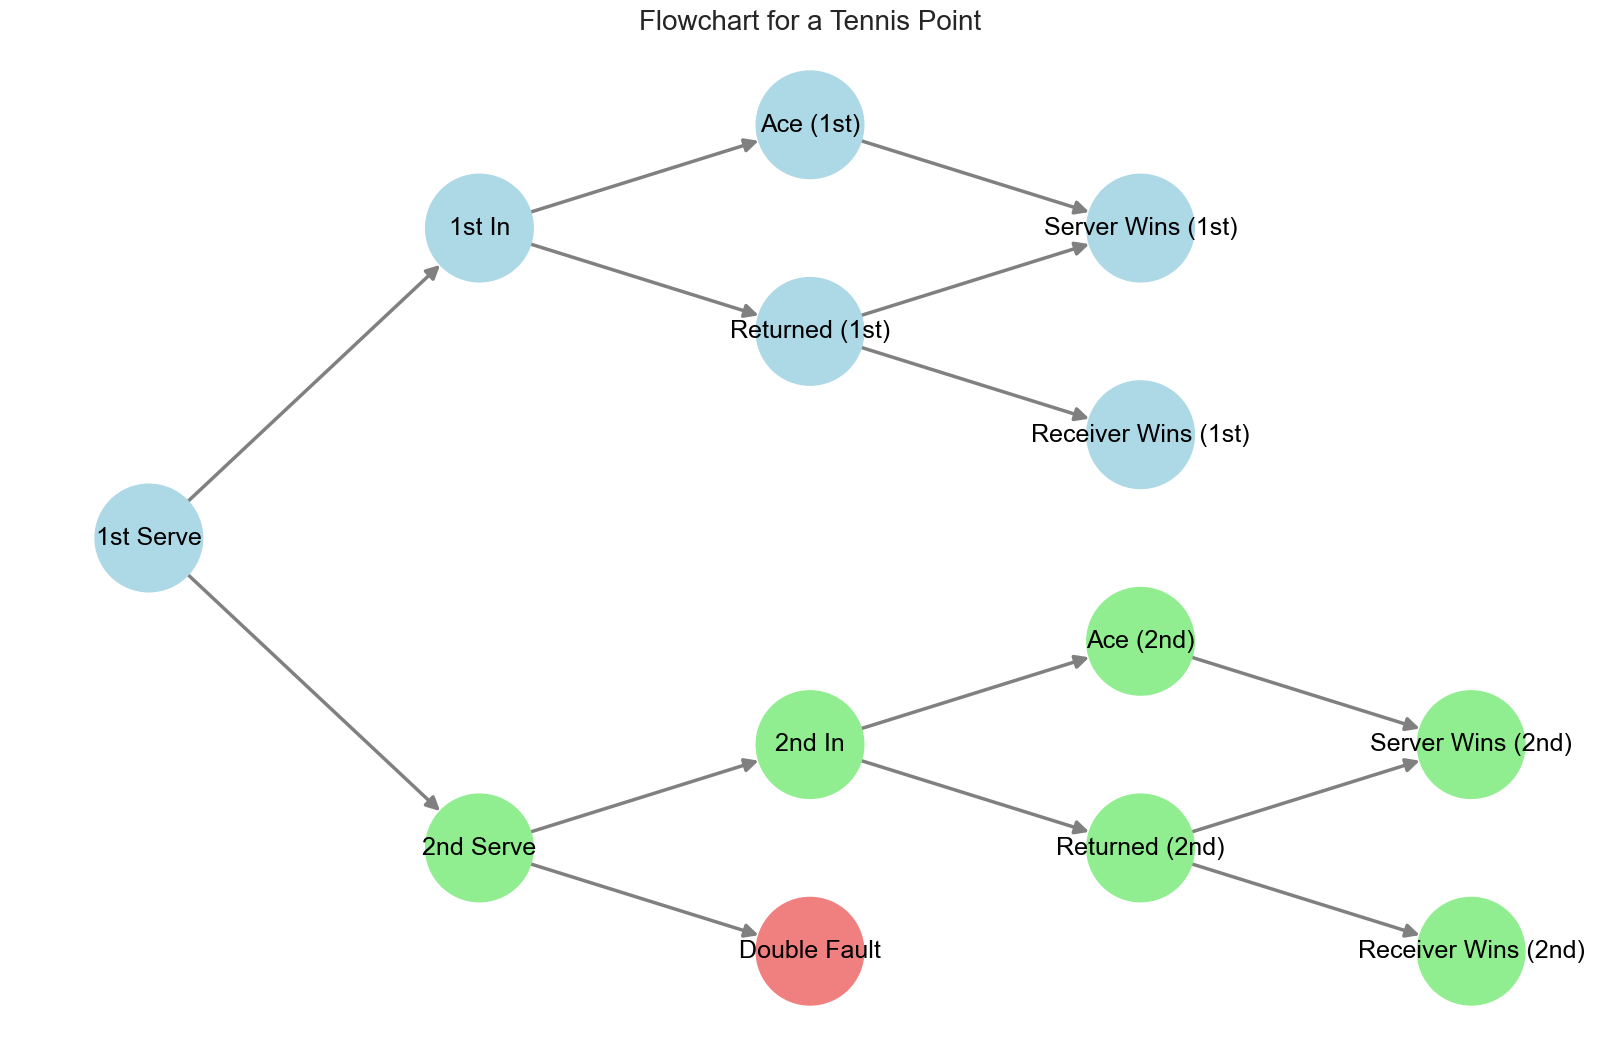

In [4]:
# Import additional libraries
import matplotlib.pyplot as plt
import networkx as nx

# Create a new directed graph
G = nx.DiGraph()

# Define the nodes and edges based on the user-provided flow
nodes = [
    "1st Serve", "1st In", "Ace (1st)", "Returned (1st)", "Server Wins (1st)", "Receiver Wins (1st)",
    "2nd Serve", "2nd In", "Ace (2nd)", "Returned (2nd)", "Server Wins (2nd)", "Receiver Wins (2nd)",
    "Double Fault"
]
edges = [
    ("1st Serve", "1st In"), ("1st In", "Ace (1st)"), ("1st In", "Returned (1st)"),
    ("Ace (1st)", "Server Wins (1st)"),
    ("Returned (1st)", "Server Wins (1st)"), ("Returned (1st)", "Receiver Wins (1st)"),
    ("1st Serve", "2nd Serve"), ("2nd Serve", "2nd In"), ("2nd In", "Ace (2nd)"),
    ("Ace (2nd)", "Server Wins (2nd)"),
    ("2nd In", "Returned (2nd)"), ("Returned (2nd)", "Server Wins (2nd)"), ("Returned (2nd)", "Receiver Wins (2nd)"),
    ("2nd Serve", "Double Fault")
]

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Define positions for the nodes in a tree-like structure (left-to-right)
tree_pos = {
    "1st Serve": (0, 0),
    "1st In": (1, 3), "Ace (1st)": (2, 4), "Returned (1st)": (2, 2), "Server Wins (1st)": (3, 3), "Receiver Wins (1st)": (3, 1),
    "2nd Serve": (1, -3), "2nd In": (2, -2), "Ace (2nd)": (3, -1), "Returned (2nd)": (3, -3), "Server Wins (2nd)": (4, -2), "Receiver Wins (2nd)": (4, -4),
    "Double Fault": (2, -4)
}


# Define node colors by type of event
node_colors = {
    "1st Serve": "lightblue", "1st In": "lightblue", "Ace (1st)": "lightblue", "Returned (1st)": "lightblue", "Server Wins (1st)": "lightblue", "Receiver Wins (1st)": "lightblue",
    "2nd Serve": "lightgreen", "2nd In": "lightgreen", "Ace (2nd)": "lightgreen", "Returned (2nd)": "lightgreen", "Server Wins (2nd)": "lightgreen", "Receiver Wins (2nd)": "lightgreen",
    "Double Fault": "lightcoral"
}

node_colors_list = [node_colors[node] for node in G.nodes]

# Draw the graph as a tree (left-to-right)
plt.figure(figsize=(16, 10))
#nx.draw(G, tree_pos, with_labels=True, node_color='lightblue', font_weight='bold', node_size=5000, font_size=20, arrows=True)
nx.draw(G, tree_pos, 
        node_color=node_colors_list, node_size=6000, 
        edge_color='grey', width=2.5, arrows=True, arrowsize=20,
        with_labels=True, font_size=18, font_color='black', font_weight='normal')

plt.savefig("_images/tennis_point_flowchart.png")

plt.title("Flowchart for a Tennis Point", fontsize=20)
plt.show()


### FEATURE EXTRACTION ###

In [5]:
# Function to form match dataset for each player
def get_player_data(player_id, start_date, end_date, current_idx, match_surface=None):
    player_filter = (df['p1_id'] == player_id) | (df['p2_id'] == player_id)
    date_filter = (df['match_date'] > start_date) & (df['match_date'] <= end_date)
    surface_filter = (df['surface'] == match_surface) if match_surface else True
    player_data = df[player_filter & date_filter & surface_filter]
    player_data = player_data[player_data.index < current_idx]
    return player_data

# Function to filter matches with common opponents of two players
def filter_by_common_opponents(player_data1, player_data2, player_id1, player_id2):
    opponents_p1 = get_opponents(player_data1, player_id1)
    opponents_p2 = get_opponents(player_data2, player_id2)
    common_opponent_ids = opponents_p1.intersection(opponents_p2)
    filtered_player_data1 = player_data1[player_data1['p1_id'].isin(common_opponent_ids) | player_data1['p2_id'].isin(common_opponent_ids)]
    filtered_player_data2 = player_data2[player_data2['p1_id'].isin(common_opponent_ids) | player_data2['p2_id'].isin(common_opponent_ids)]
    return filtered_player_data1, filtered_player_data2
    
# Function to get the set of opponents for a given player
def get_opponents(player_data, player_id):
    return set(player_data['p2_id'].loc[player_data['p1_id'] == player_id]).union(player_data['p1_id'].loc[player_data['p2_id'] == player_id])

# Function to calculate the time-weighted discount factor
def calculate_weight(match_date, current_date, discount_period, discount_factor):
    t = (current_date - match_date).days / discount_period
    weight = min(pow(discount_factor, t), discount_factor)
    return weight

# Function to calculate uncertainty and difference of given metrics between two players
def calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_metric, p2_metric, uncertainty_threshold):
    if p1_total_weight is None or p2_total_weight is None:
        return 0
    uncertainty = 1 / (p1_total_weight * p2_total_weight)
    if uncertainty >= uncertainty_threshold:
        return 0
    else:
        return p1_metric - p2_metric

# Function to plot a histogram of a given column
def plot_histogram(column, bins=50, kde=False):
    plt.figure(figsize=(10, 6))
    sns.histplot(column, bins=bins, kde=kde)
    plt.title(f'Distribution of {column.name}')
    plt.xlabel(column.name)
    plt.ylabel('Frequency')
    plt.show()

# Function to show win rate of favorite by a specific column
def show_favorite_win_rate(column):
    result_df = df.groupby(column)['favorite_won'].agg(['sum', 'count'])
    result_df.columns = ['Win Counts', 'Total Counts']
    result_df["Favorite's Win Rate"] = result_df['Win Counts'] / result_df['Total Counts'] * 100
    result_df = result_df.sort_values(by='Total Counts', ascending=False)
    display(result_df)


##### If Favorite Player Won The Match #####

,Win Counts,Total Counts,Favorite's Win Rate
favorite_won,,,
1,22510,22510,100.00
0,0,11611,0.00


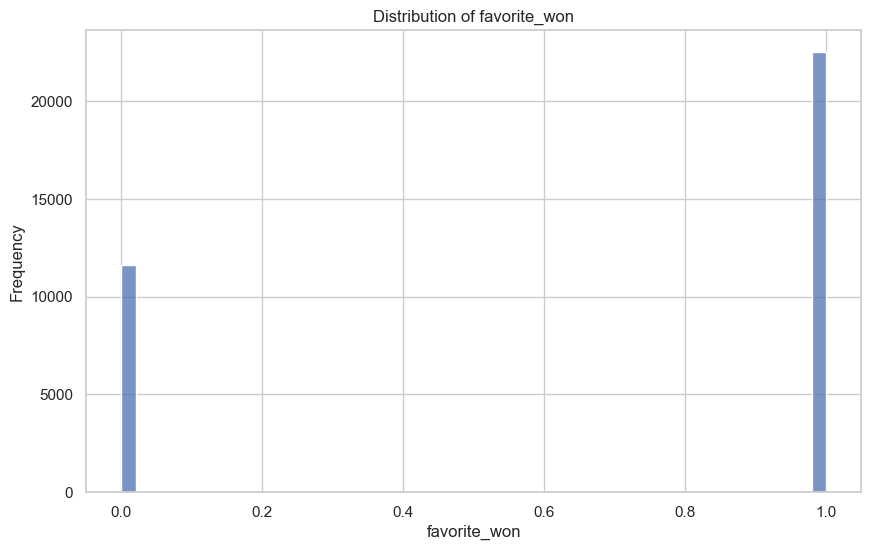

In [6]:
df['favorite_won'] = np.where((df['p1_rank'] < df['p2_rank']) & (df['p1_won'] == 1) | 
                              (df['p2_rank'] < df['p1_rank']) & (df['p1_won'] == 0), 1, 0)

show_favorite_win_rate('favorite_won')
plot_histogram(df['favorite_won'], bins=50, kde=False)

##### Implied Probability

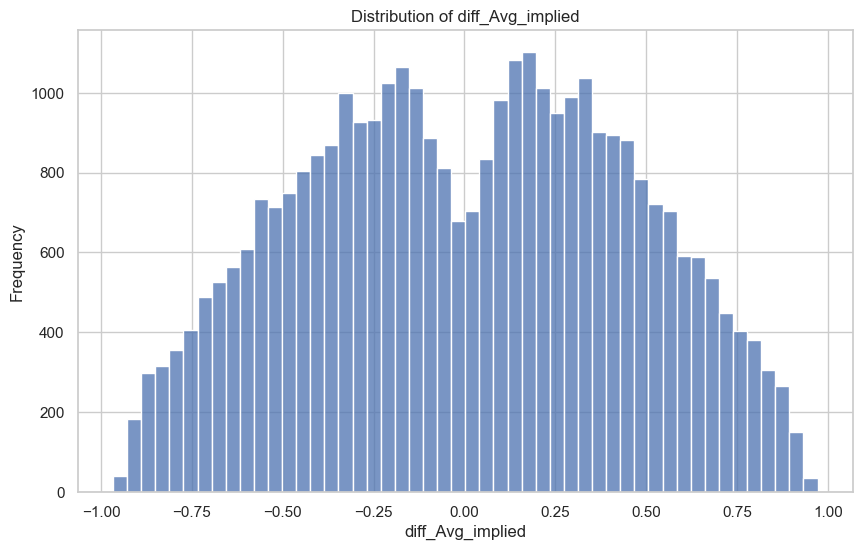

In [7]:
def calculate_normalized_implied_prob(df, odd_type):
    # Calculating the implied probabilities using Shin's method
    df[f'p1_{odd_type}_implied'] = 1 / df[f'p1_{odd_type}']
    df[f'p2_{odd_type}_implied'] = 1 / df[f'p2_{odd_type}']

    # Calculating the total probability
    total_prob = df[f'p1_{odd_type}_implied'] + df[f'p2_{odd_type}_implied']

    # # List rows where total_prob < 1
    # rows_with_less_than_one = df[total_prob < 1]
    # display(rows_with_less_than_one[[f'p1_{odd_type}', f'p2_{odd_type}', f'p1_{odd_type}_implied', f'p2_{odd_type}_implied']])

    # Normalizing the implied probabilities
    df[f'p1_{odd_type}_implied'] = df[f'p1_{odd_type}_implied'] / total_prob
    df[f'p2_{odd_type}_implied'] = df[f'p2_{odd_type}_implied'] / total_prob

# Apply the function for both Avg and Max
calculate_normalized_implied_prob(df, 'Avg')
calculate_normalized_implied_prob(df, 'Max')

# Calculate the difference between the implied probabilities
df['diff_Avg_implied'] = df['p1_Avg_implied'] - df['p2_Avg_implied']

plot_histogram(df['diff_Avg_implied'], bins=50, kde=False)


##### Ratios of Sets, Games, and Points #####

,Win Counts,Total Counts,Favorite's Win Rate
p1_points_ratio,,,
0.50,213,408,52.21
0.43,106,159,66.67
0.57,112,151,74.17
0.44,93,128,72.66
0.45,82,124,66.13
...,...,...,...
0.50,0,1,0.00
0.50,0,1,0.00
0.50,0,1,0.00


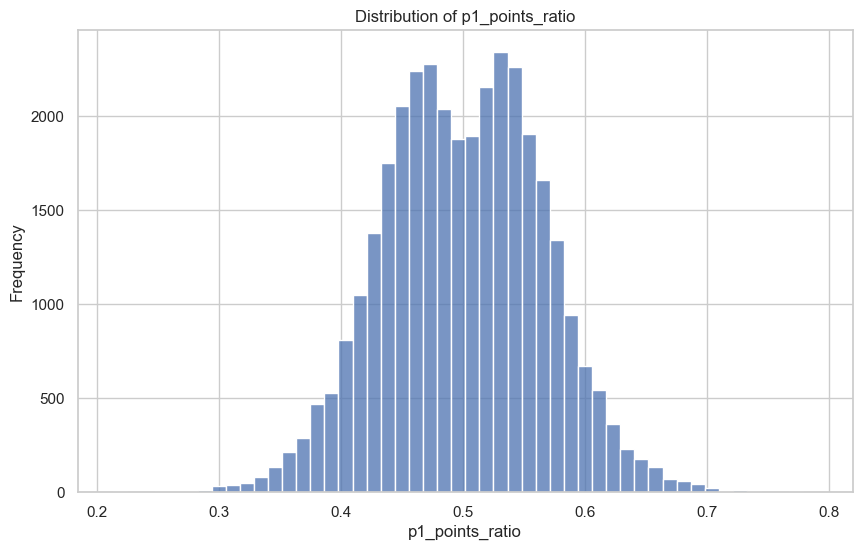

In [8]:
# Calculate points, sets and games ratios of p1 and p2
df['p1_points_ratio'] = df['p1_points'] / (df['p1_points'] + df['p2_points'])
df['p2_points_ratio'] = df['p2_points'] / (df['p1_points'] + df['p2_points'])
df['p1_games_ratio'] = df['p1_games'] / (df['p1_games'] + df['p2_games'])
df['p2_games_ratio'] = df['p2_games'] / (df['p1_games'] + df['p2_games'])
df['p1_sets_ratio'] = df['p1_sets'] / (df['p1_sets'] + df['p2_sets'])
df['p2_sets_ratio'] = df['p2_sets'] / (df['p1_sets'] + df['p2_sets'])

show_favorite_win_rate('p1_points_ratio')
plot_histogram(df['p1_points_ratio'], bins=50, kde=False)

##### Rank and Rank Points Difference #####

,Win Counts,Total Counts,Favorite's Win Rate
diff_rank_log,,,
0.00,269,526,51.14
0.48,149,288,51.74
-0.70,161,285,56.49
1.11,172,279,61.65
0.60,150,277,54.15
...,...,...,...
-2.69,1,1,100.00
-2.70,1,1,100.00
-2.70,1,1,100.00


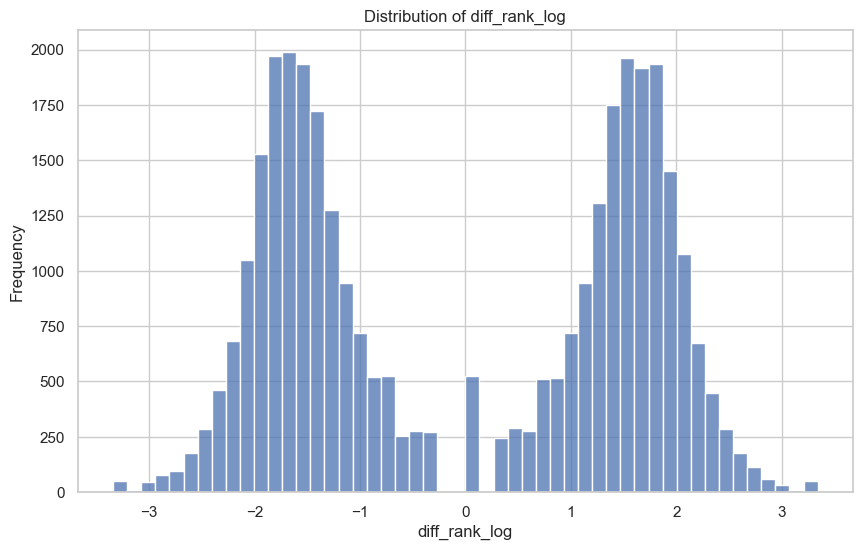

,Win Counts,Total Counts,Favorite's Win Rate
diff_rankpt_log,,,
2.12,9,32,28.12
-1.79,14,32,43.75
-2.03,18,32,56.25
-2.31,19,31,61.29
-0.78,16,31,51.61
...,...,...,...
-3.42,1,1,100.00
-3.42,1,1,100.00
-3.42,1,1,100.00


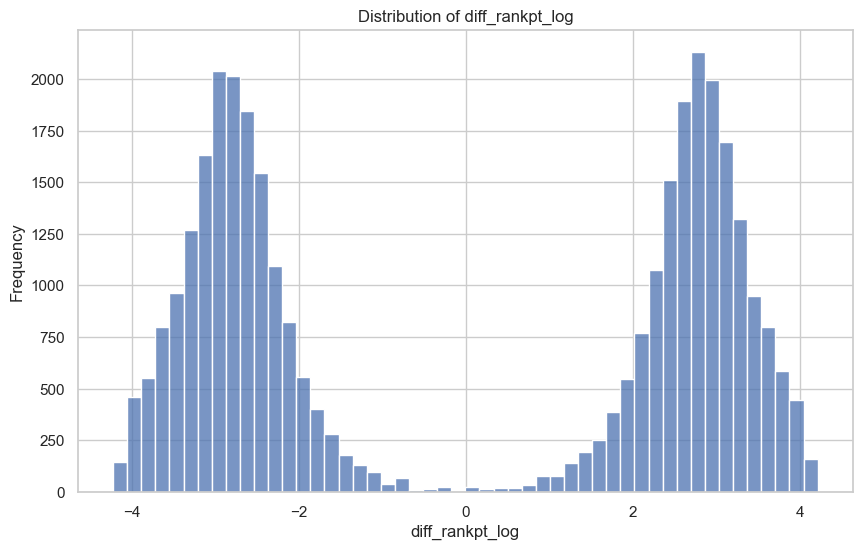

In [9]:
# Calculate the difference between the ranks and the rank points of the two players
df['diff_rank'] = df['p1_rank'] - df['p2_rank']
df['diff_rank_log'] = np.sign(df['diff_rank']) * np.log10(np.abs(df['diff_rank']))
df['diff_rankpt'] = df['p1_rankpt'] - df['p2_rankpt']
df['diff_rankpt_log'] = np.sign(df['diff_rankpt']) * np.log10(np.abs(df['diff_rankpt']) + 1)

show_favorite_win_rate('diff_rank_log')
plot_histogram(df['diff_rank_log'], bins=50, kde=False)

show_favorite_win_rate('diff_rankpt_log')
plot_histogram(df['diff_rankpt_log'], bins=50, kde=False)

##### Statistics Difference #####

In [10]:
### Number of serve games won
df['p1_SvGmsWon'] = df['p1_SvGms'] - (df['p1_bpFaced'] - df['p1_bpSaved'])
df['p2_SvGmsWon'] = df['p2_SvGms'] - (df['p2_bpFaced'] - df['p2_bpSaved'])

### Number of receive games won
df['p1_RcGmsWon'] = df['p2_bpFaced'] - df['p2_bpSaved']
df['p2_RcGmsWon'] = df['p1_bpFaced'] - df['p1_bpSaved']

# Calculate the number of second serves successfully put into play
df['p1_2ndIn'] = df['p1_svpt'] - df['p1_1stIn'] - df['p1_df']
df['p2_2ndIn'] = df['p2_svpt'] - df['p2_1stIn'] - df['p2_df']

In [11]:
### First serve in ratio
df['p1_firstServeInRatio'] = df['p1_1stIn'] / df['p1_svpt']
df['p2_firstServeInRatio'] = df['p2_1stIn'] / df['p2_svpt']

### First serve win ratio
df['p1_firstServeWinRatio'] = df['p1_1stWon'] / df['p1_1stIn']
df['p2_firstServeWinRatio'] = df['p2_1stWon'] / df['p2_1stIn']

### Second serve win ratio
df['p1_secondServeWinRatio'] = df['p1_2ndWon'] / df['p1_2ndIn']
df['p2_secondServeWinRatio'] = df['p2_2ndWon'] / df['p2_2ndIn']

### Overall serve win ratio
df['p1_overallServeWinRatio'] = (df['p1_1stWon'] + df['p1_2ndWon']) / df['p1_svpt']
df['p2_overallServeWinRatio'] = (df['p2_1stWon'] + df['p2_2ndWon']) / df['p2_svpt']

### Overall return win ratio
df['p1_overallReturnWinRatio'] = ((df['p2_1stIn'] - df['p2_1stWon']) + (df['p2_2ndIn'] - df['p2_2ndWon']) + df['p2_df']) / df['p2_svpt']
df['p2_overallReturnWinRatio'] = ((df['p2_1stIn'] - df['p2_1stWon']) + (df['p2_2ndIn'] - df['p2_2ndWon']) + df['p2_df']) / df['p1_svpt']

### Completeness
df['p1_completeness'] = df['p1_overallServeWinRatio'] * df['p1_overallReturnWinRatio']
df['p2_completeness'] = df['p2_overallServeWinRatio'] * df['p2_overallReturnWinRatio']

### Number of aces per serve points
df['p1_acePerServePoint'] = df['p1_ace'] / df['p1_svpt']
df['p2_acePerServePoint'] = df['p2_ace'] / df['p2_svpt']

### Number of double faults per serve points
df['p1_dfPerServePoint'] = df['p1_df'] / df['p1_svpt']
df['p2_dfPerServePoint'] = df['p2_df'] / df['p2_svpt']

### Number of aces per serve games
df['p1_acePerServeGame'] = df['p1_ace'] / df['p1_SvGms']
df['p2_acePerServeGame'] = df['p2_ace'] / df['p2_SvGms']

### Number of double faults per serve games
df['p1_dfPerServeGame'] = df['p1_df'] / df['p1_SvGms']
df['p2_dfPerServeGame'] = df['p2_df'] / df['p2_SvGms']

### Saved break points ratio
df['p1_bpSaveRatio'] = df['p1_bpSaved'] / df['p1_bpFaced']
df['p2_bpSaveRatio'] = df['p2_bpSaved'] / df['p2_bpFaced']

# List of columns to replace NaN values
columns_to_replace_nan = [
    'p1_firstServeInRatio', 'p2_firstServeInRatio',
    'p1_firstServeWinRatio', 'p2_firstServeWinRatio',
    'p1_secondServeWinRatio', 'p2_secondServeWinRatio',
    'p1_overallServeWinRatio', 'p2_overallServeWinRatio',
    'p1_overallReturnWinRatio', 'p2_overallReturnWinRatio',
    'p1_completeness', 'p2_completeness',
    'p1_acePerServePoint', 'p2_acePerServePoint',
    'p1_dfPerServePoint', 'p2_dfPerServePoint',
    'p1_acePerServeGame', 'p2_acePerServeGame',
    'p1_dfPerServeGame', 'p2_dfPerServeGame',
    'p1_bpSaveRatio', 'p2_bpSaveRatio'
]

# Replace NaN values with 0
df[columns_to_replace_nan] = df[columns_to_replace_nan].fillna(0)

# Print missing values in each column
display(pd.DataFrame(df.isnull().sum(), columns=['Missing']).sort_values(by='Missing', ascending=False).head(10))


,Missing
p1_entry,27718
p2_entry,27471
match_id,0
diff_rankpt_log,0
diff_rankpt,0
diff_rank_log,0
diff_rank,0
p2_sets_ratio,0
p1_sets_ratio,0
p2_games_ratio,0


In [12]:
%%script echo skipped
### GRID SEARCH ###
# Function to calculate weighted stats for a specific player with time discount factor
def calculate_stat(player_id, player_data, start_date, end_date, discount_period, discount_factor, stat_name):
    stat_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        specific_stat = f'p1_{stat_name}' if player_id == row['p1_id'] else f'p2_{stat_name}'
        stat_sum += weight * row[specific_stat]
        total_weight += weight

    stat_ratio = stat_sum / total_weight if total_weight else None

    return (stat_ratio, total_weight) if not player_data.empty else (None, None)

# Function to calculate the difference in in-game statistics for a match
def calculate_stat_difference(row, stat_name, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])
    
    p1_stat, p1_total_weight = calculate_stat(row['p1_id'], p1_data, start_date, end_date, discount_period, discount_factor, stat_name)
    p2_stat, p2_total_weight = calculate_stat(row['p2_id'], p2_data, start_date, end_date, discount_period, discount_factor, stat_name)
    
    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_stat, p2_stat, uncertainty_threshold)

# Define ranges for the parameters
time_frame_range = [365, 365*3, 365*20]
common_opponents_range = [True, False]
discount_period_range = [30, 90, 365]
discount_factor_range = [0.8, 0.9, 0.95]
uncertainty_threshold_range = [0.2, 1, 5]

# Define the statistical features to calculate
STAT_NAMES = [
    'firstServeInRatio',
    'firstServeWinRatio',
    'secondServeWinRatio',
    'overallServeWinRatio',
    'overallReturnWinRatio',
    'completeness',
    'acePerServePoint',
    'dfPerServePoint',
    'acePerServeGame',
    'dfPerServeGame',
    'bpSaveRatio'
]

# Iterate over each stat_name and parameter combination
for stat_name in STAT_NAMES:
    print(f'{stat_name} is being calculated...')

    # Store results
    results = []

    # Total iterations for progress tracking
    total_iterations = len(time_frame_range) * len(common_opponents_range) * len(discount_period_range) * len(discount_factor_range) * len(uncertainty_threshold_range)
    current_iteration = 1

    for time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold in product(
            time_frame_range, common_opponents_range, discount_period_range, discount_factor_range, uncertainty_threshold_range):

        # Calculate the feature with the current set of parameters
        df[f'diff_{stat_name}'] = df.apply(
            lambda row: calculate_stat_difference(
                row, stat_name=stat_name, time_frame=time_frame, common_opponents=common_opponents, 
                discount_period=discount_period, discount_factor=discount_factor, uncertainty_threshold=uncertainty_threshold
            ), axis=1
        )

        # Calculate mutual information score for the feature
        mi_score = mutual_info_classif(df[[f'diff_{stat_name}']], df['p1_won'], discrete_features=True, random_state=42)[0]

        # Initialize the MinMaxScaler
        scaler = MinMaxScaler()

        # Prepare the feature
        X = df[[f'diff_{stat_name}']].fillna(0)

        # Scale the feature to [0, 1]
        X_scaled = scaler.fit_transform(X)

        # Prepare the target
        y = df['p1_won']

        # Calculate chi-square score for the feature
        chi2_score, p_values = chi2(X_scaled, y)

        # Append the results
        results.append({
            'common_opponents': common_opponents,
            'discount_period': discount_period,
            'discount_factor': discount_factor,
            'time_frame': time_frame,
            'uncertainty_threshold': uncertainty_threshold,
            'Chi2_Score': chi2_score[0],
            'P_Value': p_values[0]
        })

        # Drop the column to prepare for the next iteration
        df.drop(f'diff_{stat_name}', axis=1, inplace=True)

        # Display the results
        clear_output(wait=True)
        results_df = pd.DataFrame(results)
        sorted_results = results_df.sort_values(by='Chi2_Score', ascending=False)
        display(sorted_results.head(200))

        # Print progress update
        print(f"Completed iteration {current_iteration}/{total_iterations} for {stat_name} at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        current_iteration += 1

    # Export sorted results to a CSV file inside the '_fe' folder
    sorted_results.to_csv(f'_fe/diff_{stat_name}.csv', index=False)


skipped


In [13]:
# Function to calculate weighted stats for a specific player with time discount factor
def calculate_stat(player_id, player_data, start_date, end_date, discount_period, discount_factor, stat_name):
    stat_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        specific_stat = f'p1_{stat_name}' if player_id == row['p1_id'] else f'p2_{stat_name}'
        stat_sum += weight * row[specific_stat]
        total_weight += weight

    stat_ratio = stat_sum / total_weight if total_weight else None

    return (stat_ratio, total_weight) if not player_data.empty else (None, None)

# Function to calculate the difference in in-game statistics for a match
def calculate_stat_difference(row, stat_name, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])
    
    p1_stat, p1_total_weight = calculate_stat(row['p1_id'], p1_data, start_date, end_date, discount_period, discount_factor, stat_name)
    p2_stat, p2_total_weight = calculate_stat(row['p2_id'], p2_data, start_date, end_date, discount_period, discount_factor, stat_name)

    # # For debugging
    # display(p1_data[['p1_id', 'p2_id', f'p1_{stat_name}', f'p2_{stat_name}', 'match_date']].sort_values(by=['p1_id', 'match_date']))
    # p1_data[['p1_id', 'p2_id', f'p1_{stat_name}', f'p2_{stat_name}', 'match_date']].sort_values(by=['p1_id', 'match_date']).to_clipboard()
    # display(p2_data[['p1_id', 'p2_id', f'p1_{stat_name}', f'p2_{stat_name}', 'match_date']].sort_values(by=['p2_id', 'match_date']))
    # p2_data[['p1_id', 'p2_id', f'p1_{stat_name}', f'p2_{stat_name}', 'match_date']].sort_values(by=['p2_id', 'match_date']).to_clipboard()
    # print(p1_stat, p2_stat)
    
    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_stat, p2_stat, uncertainty_threshold)

# STAT_NAMES = [
#     'firstServeInRatio',
#     'firstServeWinRatio',
#     'secondServeWinRatio',
#     'overallServeWinRatio',
#     'overallReturnWinRatio',
#     'completeness',
#     'acePerServePoint',
#     'dfPerServePoint',
#     'acePerServeGame',
#     'dfPerServeGame',
#     'bpSaveRatio'
# ]

# for stat_name in STAT_NAMES:
#     print(f'{stat_name} is being calculated...')
#     df[f'diff_{stat_name}'] = df.apply(
#         lambda row: calculate_stat_difference(
#             row, stat_name=stat_name, time_frame=365*20, common_opponents=False, discount_period=365, discount_factor=0.8, uncertainty_threshold=1
#         ), axis=1
#     )

print('firstServeInRatio is being calculated...')
df['diff_firstServeInRatio'] = df.apply(lambda row: calculate_stat_difference(row, stat_name='firstServeInRatio', time_frame=365*20, common_opponents=False, discount_period=90, discount_factor=0.8, uncertainty_threshold=0.2), axis=1)
print('firstServeWinRatio is being calculated...')
df['diff_firstServeWinRatio'] = df.apply(lambda row: calculate_stat_difference(row, stat_name='firstServeWinRatio', time_frame=365*3, common_opponents=True, discount_period=90, discount_factor=0.9, uncertainty_threshold=0.2), axis=1)
print('secondServeWinRatio is being calculated...')
df['diff_secondServeWinRatio'] = df.apply(lambda row: calculate_stat_difference(row, stat_name='secondServeWinRatio', time_frame=365*3, common_opponents=True, discount_period=365, discount_factor=0.9, uncertainty_threshold=0.2), axis=1)
print('overallServeWinRatio is being calculated...')
df['diff_overallServeWinRatio'] = df.apply(lambda row: calculate_stat_difference(row, stat_name='overallServeWinRatio', time_frame=365*20, common_opponents=True, discount_period=90, discount_factor=0.8, uncertainty_threshold=0.2), axis=1)
print('overallReturnWinRatio is being calculated...')
df['diff_overallReturnWinRatio'] = df.apply(lambda row: calculate_stat_difference(row, stat_name='overallReturnWinRatio', time_frame=365*20, common_opponents=True, discount_period=90, discount_factor=0.8, uncertainty_threshold=0.2), axis=1)
print('completeness is being calculated...')
df['diff_completeness'] = df.apply(lambda row: calculate_stat_difference(row, stat_name='completeness', time_frame=365*20, common_opponents=True, discount_period=365, discount_factor=0.9, uncertainty_threshold=0.2), axis=1)
print('acePerServePoint is being calculated...')
df['diff_acePerServePoint'] = df.apply(lambda row: calculate_stat_difference(row, stat_name='acePerServePoint', time_frame=365*3, common_opponents=False, discount_period=90, discount_factor=0.8, uncertainty_threshold=0.2), axis=1)
print('dfPerServePoint is being calculated...')
df['diff_dfPerServePoint'] = df.apply(lambda row: calculate_stat_difference(row, stat_name='dfPerServePoint', time_frame=365*20, common_opponents=True, discount_period=365, discount_factor=0.95, uncertainty_threshold=0.2), axis=1)
print('acePerServeGame is being calculated...')
df['diff_acePerServeGame'] = df.apply(lambda row: calculate_stat_difference(row, stat_name='acePerServeGame', time_frame=365*3, common_opponents=False, discount_period=30, discount_factor=0.95, uncertainty_threshold=5.0), axis=1)
print('diff_dfPerServeGame is being calculated...')
df['diff_dfPerServeGame'] = df.apply(lambda row: calculate_stat_difference(row, stat_name='dfPerServeGame', time_frame=365*3, common_opponents=True, discount_period=365, discount_factor=0.95, uncertainty_threshold=0.2), axis=1)
print('diff_bpSaveRatio is being calculated...')
df['diff_bpSaveRatio'] = df.apply(lambda row: calculate_stat_difference(row, stat_name='bpSaveRatio', time_frame=365*3, common_opponents=True, discount_period=365, discount_factor=0.8, uncertainty_threshold=0.2), axis=1)

# # For debugging
# calculate_stat_difference(
#     row=df[df['match_id'] == '2022-0605-0300'].iloc[0], 
#     stat_name='firstServeInRatio',
#     time_frame=365*20, 
#     common_opponents=True, 
#     discount_period=365, 
#     discount_factor=1, 
#     uncertainty_threshold=1
# )


firstServeInRatio is being calculated...
firstServeWinRatio is being calculated...
secondServeWinRatio is being calculated...
overallServeWinRatio is being calculated...
overallReturnWinRatio is being calculated...
completeness is being calculated...
acePerServePoint is being calculated...
dfPerServePoint is being calculated...
acePerServeGame is being calculated...
diff_dfPerServeGame is being calculated...
diff_bpSaveRatio is being calculated...


##### Grand Slam or Not #####

,Win Counts,Total Counts,Favorite's Win Rate
is_grandSlam,,,
0,17610,27441,64.17
1,4900,6680,73.35


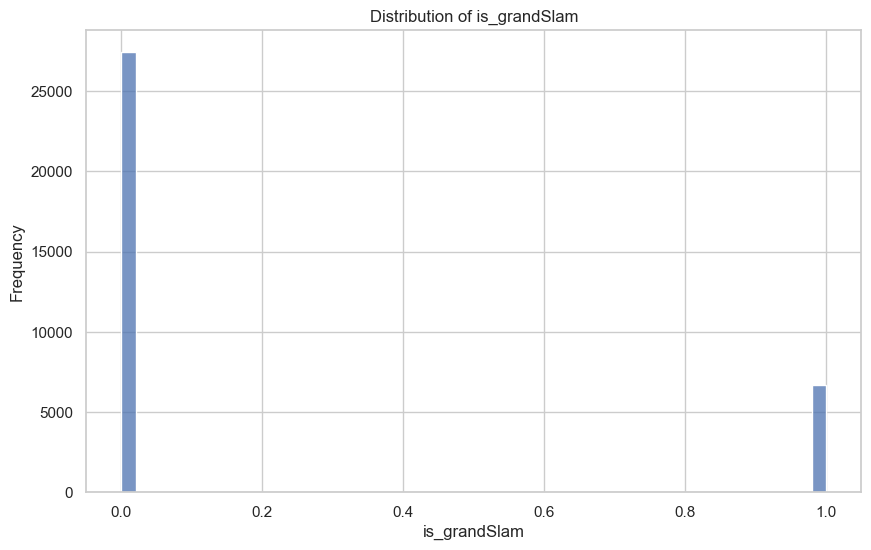

In [14]:
df['is_grandSlam'] = (df['tourney_level'] == 'G').astype(int)

show_favorite_win_rate('is_grandSlam')
plot_histogram(df['is_grandSlam'], bins=50, kde=False)


##### Former Top-10 Presence #####

In [15]:
%%script echo skipped
### GRID SEARCH ###
# Function to check if a specific player has been in the top 10
def has_been_in_top10(player_id, start_date, end_date, current_idx):
    # Filtering data for the specific player and date range
    player_matches_as_p1 = df[(df['p1_id'] == player_id) & (df['match_date'] > start_date) & (df['match_date'] <= end_date)]
    player_matches_as_p2 = df[(df['p2_id'] == player_id) & (df['match_date'] > start_date) & (df['match_date'] <= end_date)]

    # Remove the current row and future rows based on the index
    player_matches_as_p1 = player_matches_as_p1[player_matches_as_p1.index < current_idx]
    player_matches_as_p2 = player_matches_as_p2[player_matches_as_p2.index < current_idx]

    # Check if the player has been in the top 10 during the specified period
    return (player_matches_as_p1['p1_rank'] <= 10).any() or (player_matches_as_p2['p2_rank'] <= 10).any()

# Function to calculate is_formerTop10 for a match
def calculate_is_formerTop10(row, time_frame):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    return int(has_been_in_top10(row['p1_id'], start_date, end_date, row.name) or \
               has_been_in_top10(row['p2_id'], start_date, end_date, row.name))

# Define a range of time_frame values to test
time_frame_range = [15, 30, 60, 90, 180, 365, 365*2, 365*3, 365*5, 365*20]

# Create a DataFrame to store results
results = []

# Iterate over all combinations of parameters
total_iterations = len(time_frame_range)
current_iteration = 1

for time_frame in time_frame_range:
    # Calculate the feature with the current set of parameters
    df['is_formerTop10'] = df.apply(lambda row: calculate_is_formerTop10(row, time_frame), axis=1)
    
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Prepare the feature
    X = df[['is_formerTop10']].fillna(0)

    # Scale the feature to [0, 1]
    X_scaled = scaler.fit_transform(X)

    # Prepare the target
    y = df['p1_won']

    # Calculate chi-square score for the feature
    chi2_score, p_values = chi2(X_scaled, y)

    # Append the results
    results.append({
        'time_frame': time_frame,
        'Chi2_Score': chi2_score[0],
        'P_Value': p_values[0]
    })

    # Drop the column to prepare for the next iteration
    df.drop('is_formerTop10', axis=1, inplace=True)

    # Display the results
    clear_output(wait=True)
    results_df = pd.DataFrame(results)
    sorted_results = results_df.sort_values(by='Chi2_Score', ascending=False)
    display(sorted_results.head(200))

    # Print progress update
    print(f"Completed iteration {current_iteration}/{total_iterations} at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    current_iteration += 1

# Export sorted results to a CSV file inside the '_fe' folder
sorted_results.to_csv('_fe/is_formerTop10.csv', index=False)


skipped


,Win Counts,Total Counts,Favorite's Win Rate
is_formerTop10,,,
0,17396,27651,62.91
1,5114,6470,79.04


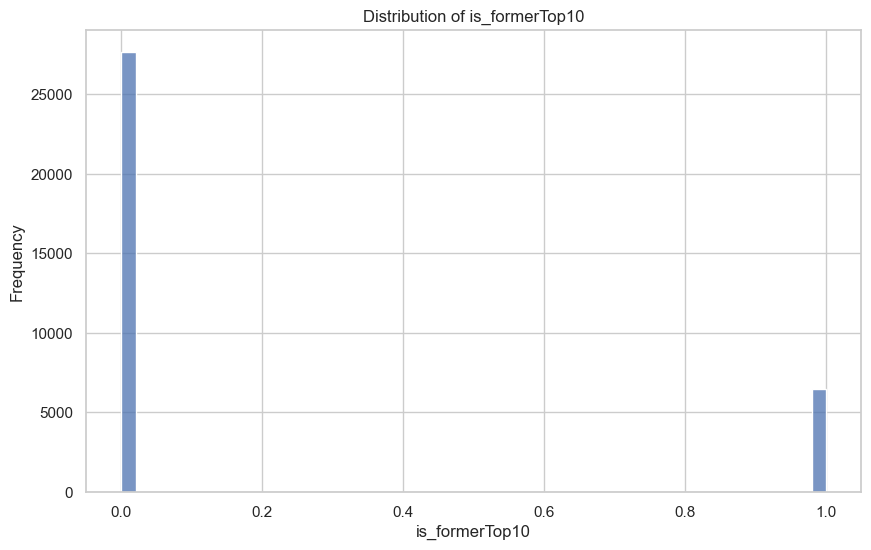

In [16]:
# Function to check if a specific player has been in the top 10
def has_been_in_top10(player_id, start_date, end_date, current_idx):
    # Filtering data for the specific player and date range
    player_matches_as_p1 = df[(df['p1_id'] == player_id) & (df['match_date'] > start_date) & (df['match_date'] <= end_date)]
    player_matches_as_p2 = df[(df['p2_id'] == player_id) & (df['match_date'] > start_date) & (df['match_date'] <= end_date)]

    # Remove the current row and future rows based on the index
    player_matches_as_p1 = player_matches_as_p1[player_matches_as_p1.index < current_idx]
    player_matches_as_p2 = player_matches_as_p2[player_matches_as_p2.index < current_idx]

    # Check if the player has been in the top 10 during the specified period
    return (player_matches_as_p1['p1_rank'] <= 10).any() or (player_matches_as_p2['p2_rank'] <= 10).any()

# Function to calculate is_formerTop10 for a match
def calculate_is_formerTop10(row, time_frame):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    return int(has_been_in_top10(row['p1_id'], start_date, end_date, row.name) or \
               has_been_in_top10(row['p2_id'], start_date, end_date, row.name))

# Apply the function to calculate the is_formerTop10 column for each match
df['is_formerTop10'] = df.apply(lambda row: calculate_is_formerTop10(row, time_frame=15), axis=1)

show_favorite_win_rate('is_formerTop10')
plot_histogram(df['is_formerTop10'], bins=50, kde=False)


##### Handedness Combinations #####

,Win Counts,Total Counts,Favorite's Win Rate
handedness,,,
R,16755,25284,66.27
RL,2807,4178,67.19
LR,2568,4013,63.99
L,380,646,58.82


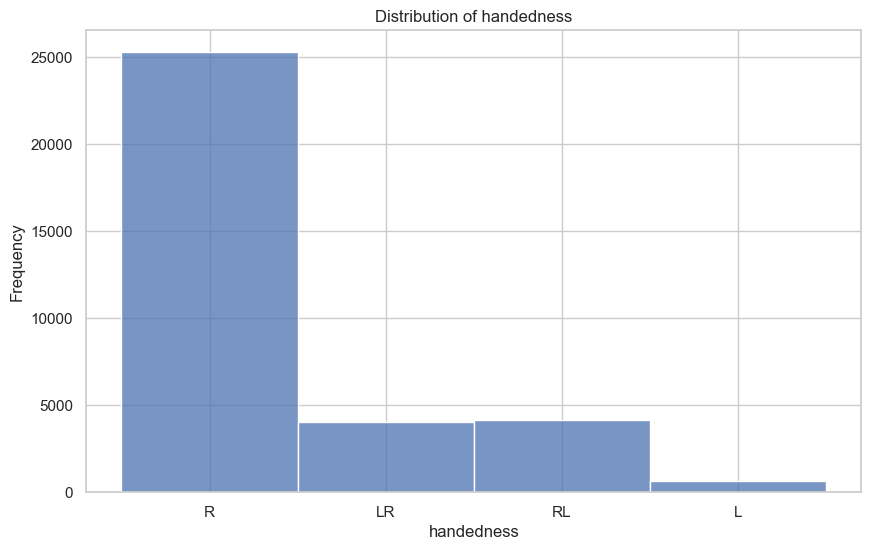

In [17]:
def categorize_hand_combinations(row):
    if row['p1_hand'] == row['p2_hand']:
        return row['p1_hand']

    if row['p1_hand'] == 'R' and row['p2_hand'] == 'L':
        if row['p1_rank'] < row['p2_rank']:  # Player 1 is favorite
            return 'RL'
        else:  # Player 2 is favorite
            return 'LR'
    if row['p1_hand'] == 'L' and row['p2_hand'] == 'R':
        if row['p1_rank'] < row['p2_rank']:  # Player 1 is favorite
            return 'LR'
        else:  # Player 2 is favorite
            return 'RL'

# Apply the function to create the new feature
df['handedness'] = df.apply(categorize_hand_combinations, axis=1)

show_favorite_win_rate('handedness')
plot_histogram(df['handedness'], bins=50, kde=False)


##### Home Advantage Difference #####

USA    8052
FRA    3733
GBR    2677
AUS    2529
GER    1665
Name: match_country_code, dtype: int64

,Win Counts,Total Counts,Favorite's Win Rate
diff_homeAdvantage,,,
0,17290,26322,65.69
1,2612,3902,66.94
-1,2608,3897,66.92


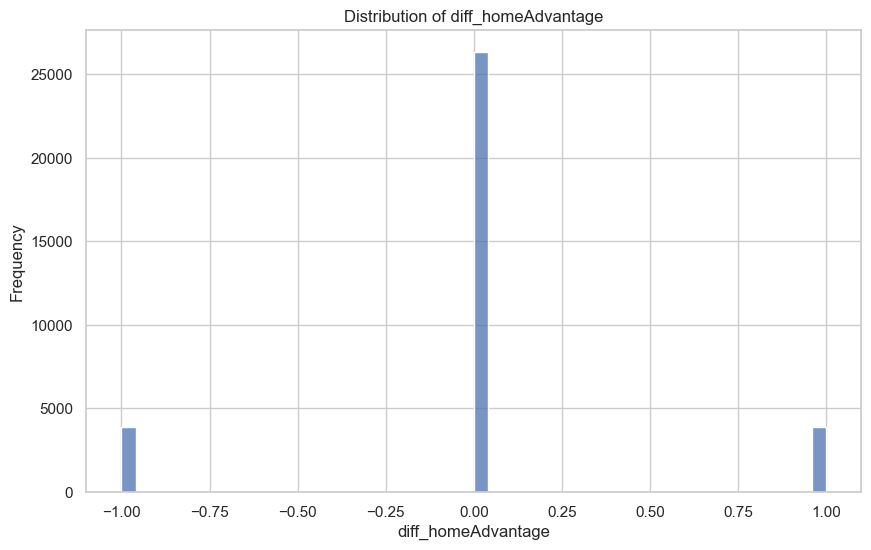

In [18]:
# Define a mapping between tourney names and corresponding country codes
location_to_country_code = {
    'Acapulco': 'MEX',
    'Adelaide': 'AUS',
    'Adelaide 1': 'AUS',
    'Adelaide 2': 'AUS',
    'Antalya': 'TUR',
    'Antwerp': 'BEL',
    'Astana': 'KAZ',
    'Atlanta': 'USA',
    'Auckland': 'NZL',
    'Australian Open': 'AUS',
    'Bangkok': 'THA',
    'Barcelona': 'ESP',
    'Basel': 'SUI',
    'Bastad': 'SWE',
    'Beijing': 'CHN',
    'Belgrade': 'SRB',
    'Belgrade 2': 'SRB',
    'Bogota': 'COL',
    'Brisbane': 'AUS',
    'Bucharest': 'ROU',
    'Budapest': 'HUN',
    'Buenos Aires': 'ARG',
    'Cagliari': 'ITA',
    'Canada Masters': 'CAN',
    'Casablanca': 'MAR',
    'Chengdu': 'CHN',
    'Chennai': 'IND',
    'Cincinnati Masters': 'USA',
    'Cologne 1': 'GER',
    'Cologne 2': 'GER',
    'Cordoba': 'ARG',
    'Costa Do Sauipe': 'BRA',
    'Dallas': 'USA',
    'Delray Beach': 'USA',
    'Doha': 'QAT',
    'Dubai': 'UAE',
    'Dusseldorf': 'GER',
    'Eastbourne': 'GBR',
    'Estoril': 'POR',
    'Florence': 'ITA',
    'Geneva': 'SUI',
    'Gijon': 'ESP',
    'Great Ocean Road Open': 'AUS',
    'Gstaad': 'SUI',
    'Halle': 'GER',
    'Hamburg': 'GER',
    'Houston': 'USA',
    'Indian Wells Masters': 'USA',
    'Indianapolis': 'USA',
    'Istanbul': 'TUR',
    'Johannesburg': 'RSA',
    'Kitzbuhel': 'AUT',
    'Kuala Lumpur': 'MYS',
    'Los Angeles': 'USA',
    'Los Cabos': 'MEX',
    'Lyon': 'FRA',
    'Madrid Masters': 'ESP',
    'Mallorca': 'ESP',
    'Marbella': 'ESP',
    'Marrakech': 'MAR',
    'Marseille': 'FRA',
    'Melbourne': 'AUS',
    'Memphis': 'USA',
    'Metz': 'FRA',
    'Miami Masters': 'USA',
    'Monte Carlo Masters': 'MON',
    'Montpellier': 'FRA',
    'Moscow': 'RUS',
    'Munich': 'GER',
    'Murray River Open': 'AUS',
    'Naples': 'ITA',
    'New Haven': 'USA',
    'New York': 'USA',
    'Newport': 'USA',
    'Nice': 'FRA',
    'Nottingham': 'GBR',
    'Paris Masters': 'FRA',
    'Parma': 'ITA',
    'Pune': 'IND',
    "Queen's Club": 'GBR',
    'Quito': 'ECU',
    'Rio de Janeiro': 'BRA',
    'Roland Garros': 'FRA',
    'Rome Masters': 'ITA',
    'Rotterdam': 'NED',
    'San Diego': 'USA',
    'San Jose': 'USA',
    'Santiago': 'CHI',
    'Sao Paulo': 'BRA',
    'Sardinia': 'ITA',
    'Seoul': 'KOR',
    'Shanghai Masters': 'CHN',
    'Shenzhen': 'CHN',
    'Singapore': 'SGP',
    'Sofia': 'BGR',
    'St. Petersburg': 'RUS',
    'Stockholm': 'SWE',
    'Stuttgart': 'GER',
    'Sydney': 'AUS',
    'Tel Aviv': 'ISR',
    'Tokyo': 'JPN',
    'Tour Finals London': 'GBR',
    'Tour Finals Turin': 'ITA',
    'US Open': 'USA',
    'Umag': 'CRO',
    'Valencia': 'ESP',
    'Vienna': 'AUT',
    'Vina del Mar': 'CHI',
    'Washington': 'USA',
    'Wimbledon': 'GBR',
    'Winston-Salem': 'USA',
    'Zagreb': 'CRO',
    'Zhuhai': 'CHN',
    's Hertogenbosch': 'NED'
}

# Apply the mapping to create a new column with country codes for the match location
df['match_country_code'] = df['tourney_name'].map(location_to_country_code)
display(df['match_country_code'].value_counts().head())

# Define a function to calculate home advantage
def calculate_home_advantage(row):
    if row['match_country_code'] == row['p1_ioc'] and row['match_country_code'] == row['p2_ioc']:
        return 0
    elif row['match_country_code'] == row['p1_ioc']:
        return 1
    elif row['match_country_code'] == row['p2_ioc']:
        return -1
    else:
        return 0

# Apply the function to create the diff_homeAdvantage column
df['diff_homeAdvantage'] = df.apply(calculate_home_advantage, axis=1)

# Drop the temporary match_country_code column
df.drop(columns=['match_country_code'], inplace=True)

show_favorite_win_rate('diff_homeAdvantage')
plot_histogram(df['diff_homeAdvantage'], bins=50, kde=False)

##### Height Difference #####

,Win Counts,Total Counts,Favorite's Win Rate
diff_ht,,,
0,2391,3591,66.58
5,1937,2946,65.75
-5,1888,2905,64.99
-3,1323,2013,65.72
3,1306,1991,65.60
...,...,...,...
38,1,2,50.00
24,1,1,100.00
-27,1,1,100.00


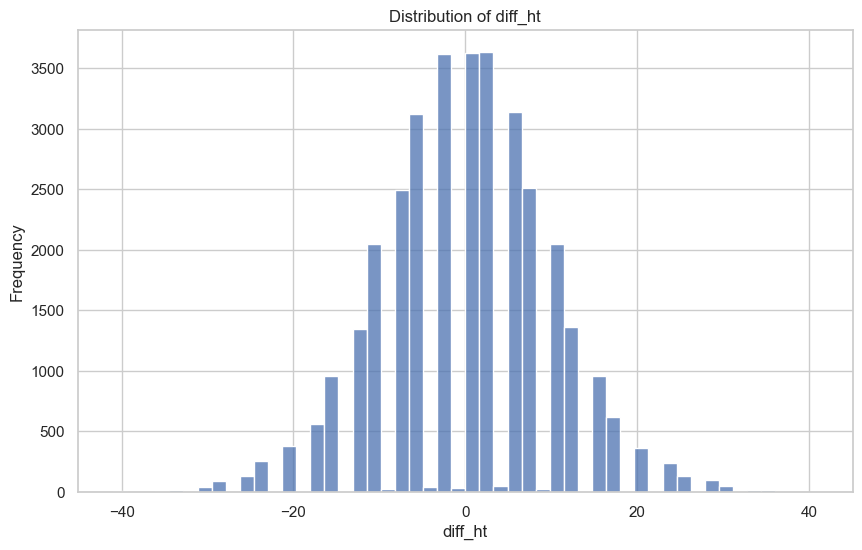

In [19]:
# Calculate the height difference
df['diff_ht'] = df['p1_ht'] - df['p2_ht']

show_favorite_win_rate('diff_ht')
plot_histogram(df['diff_ht'], bins=50, kde=False)

##### Seed Difference #####

,Win Counts,Total Counts,Favorite's Win Rate
diff_seed,,,
0.00,7576,12944,58.53
-4.00,529,861,61.44
4.00,506,778,65.04
-5.00,513,762,67.32
-6.00,467,745,62.68
...,...,...,...
-40.50,5,7,71.43
1.50,5,7,71.43
26.50,4,6,66.67


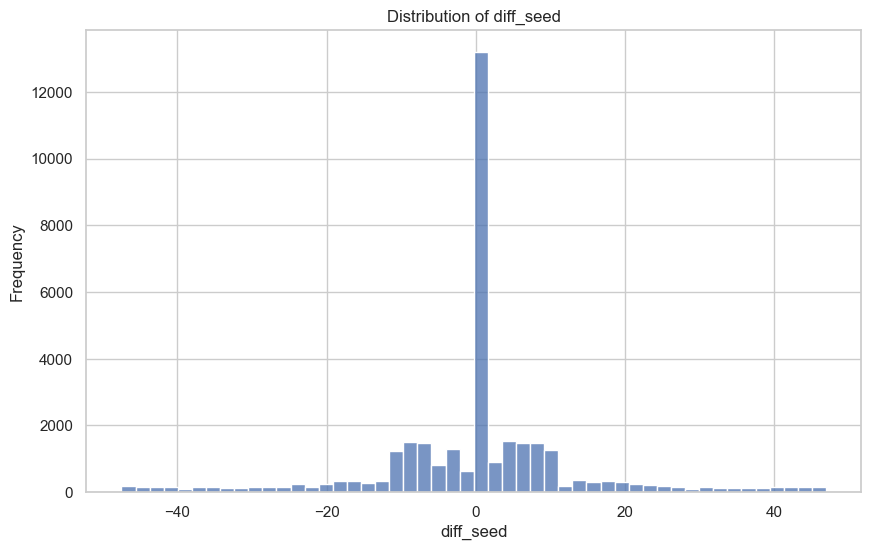

In [20]:
# Calculate the age difference
df['diff_seed'] = df['p1_seed'] - df['p2_seed']

show_favorite_win_rate('diff_seed')
plot_histogram(df['diff_seed'], bins=50, kde=False)

##### Age Difference #####

,Win Counts,Total Counts,Favorite's Win Rate
diff_age,,,
0.00,194,265,73.21
1.00,180,251,71.71
-1.00,178,250,71.20
0.50,153,232,65.95
-2.00,155,229,67.69
...,...,...,...
-3.90,1,1,100.00
-3.60,0,1,0.00
-2.40,1,1,100.00


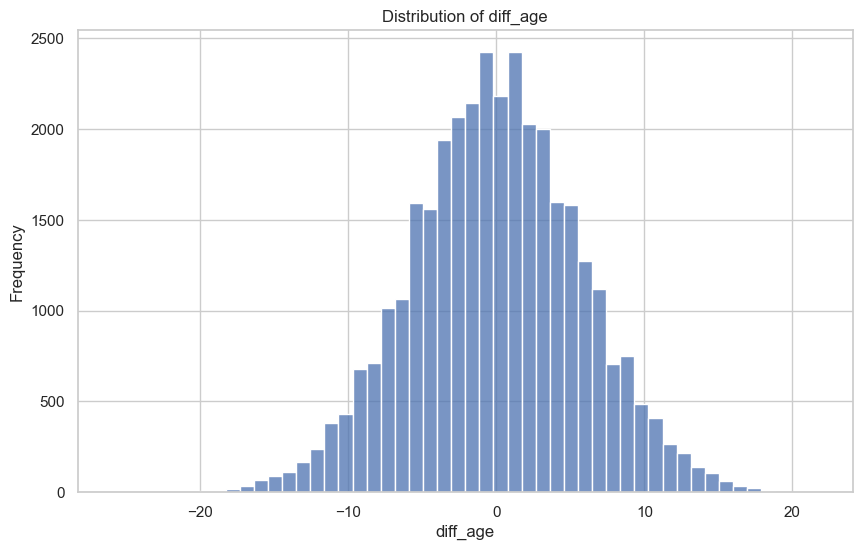

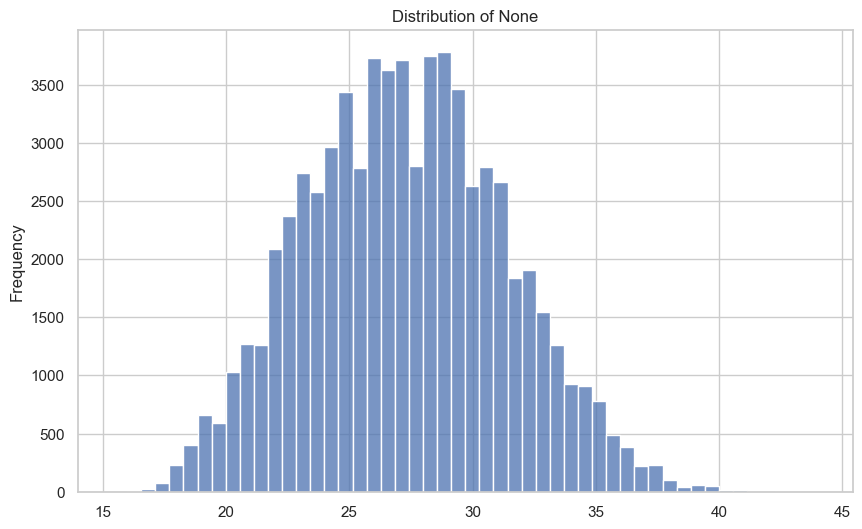

In [21]:
# Calculate the age difference
df['diff_age'] = df['p1_age'] - df['p2_age']

show_favorite_win_rate('diff_age')
plot_histogram(df['diff_age'], bins=50, kde=False)

combined_ages = pd.concat([df['p1_age'], df['p2_age']], ignore_index=True)
plot_histogram(combined_ages, bins=50, kde=False)


##### Personal Peak Ages and Current Ages Difference (Only the training data between 2009-2020 is used to avoid data leakage)

,Win Counts,Total Counts,Favorite's Win Rate
diff_agePersonalPeak,,,
0.00,1082,1704,63.50
-0.10,418,640,65.31
0.10,348,544,63.97
0.10,311,468,66.45
-0.10,301,450,66.89
...,...,...,...
-2.50,1,1,100.00
7.70,0,1,0.00
-2.20,0,1,0.00


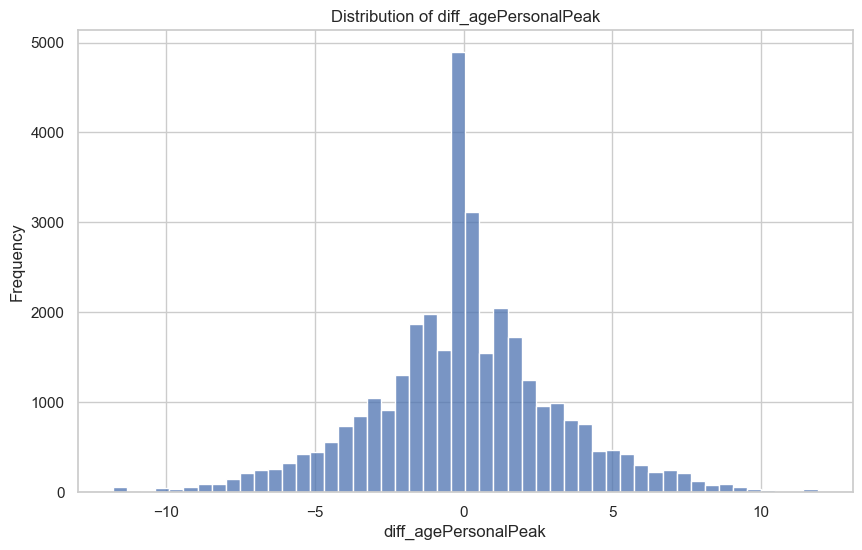

In [22]:
# Define the training data range
training_data_filter = (df['year'] >= 2009) & (df['year'] <= 2020)

# Extracting player 1 and player 2 information for training data
player1_df = df[training_data_filter][['p1_id', 'p1_name', 'p1_age', 'p1_rankpt']].copy()
player1_df.columns = ['player_id', 'player_name', 'player_age', 'player_rankpt']
player2_df = df[training_data_filter][['p2_id', 'p2_name', 'p2_age', 'p2_rankpt']].copy()
player2_df.columns = ['player_id', 'player_name', 'player_age', 'player_rankpt']

# Concatenating player 1 and player 2 data
all_players_df = pd.concat([player1_df, player2_df], ignore_index=True)

# Grouping by player ID and getting the age corresponding to the maximum rank points
peak_performance_df = all_players_df.loc[all_players_df.groupby('player_id')['player_rankpt'].idxmax()]

# Merge with original dataframe to create p1_agePersonalPeak column
df = pd.merge(df, peak_performance_df[['player_id', 'player_age']], left_on='p1_id', right_on='player_id', how='left')
df.rename(columns={'player_age': 'p1_agePersonalPeak'}, inplace=True)
df.drop(columns=['player_id'], inplace=True)

# Merge with original dataframe to create p2_agePersonalPeak column
df = pd.merge(df, peak_performance_df[['player_id', 'player_age']], left_on='p2_id', right_on='player_id', how='left')
df.rename(columns={'player_age': 'p2_agePersonalPeak'}, inplace=True)
df.drop(columns=['player_id'], inplace=True)

# Create the new feature
df['diff_agePersonalPeak'] = np.where(df['p1_agePersonalPeak'].isna() | df['p2_agePersonalPeak'].isna(), 0, 
                                     (df['p1_age'] - df['p1_agePersonalPeak']).abs() - (df['p2_age'] - df['p2_agePersonalPeak']).abs())

show_favorite_win_rate('diff_agePersonalPeak')
plot_histogram(df['diff_agePersonalPeak'], bins=50, kde=False)


##### General Peak Age and Current Ages Difference (Only the training data btw. 2009-2020 is used to avoid data leakage)

,Win Counts,Total Counts,Favorite's Win Rate
diff_ageGeneralPeak,,,
0.00,347,502,69.12
-1.00,305,431,70.77
0.50,258,410,62.93
1.00,271,405,66.91
-0.50,248,391,63.43
...,...,...,...
-8.10,1,1,100.00
-8.50,0,1,0.00
-9.20,0,1,0.00


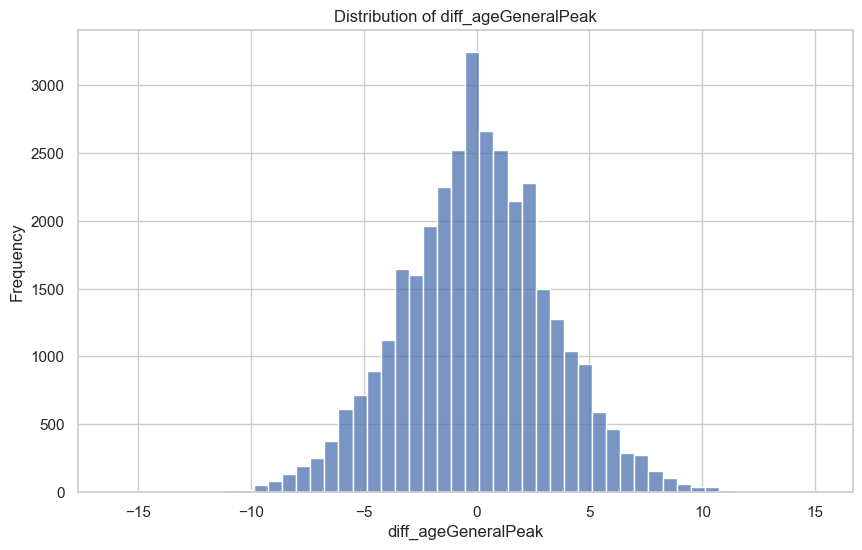

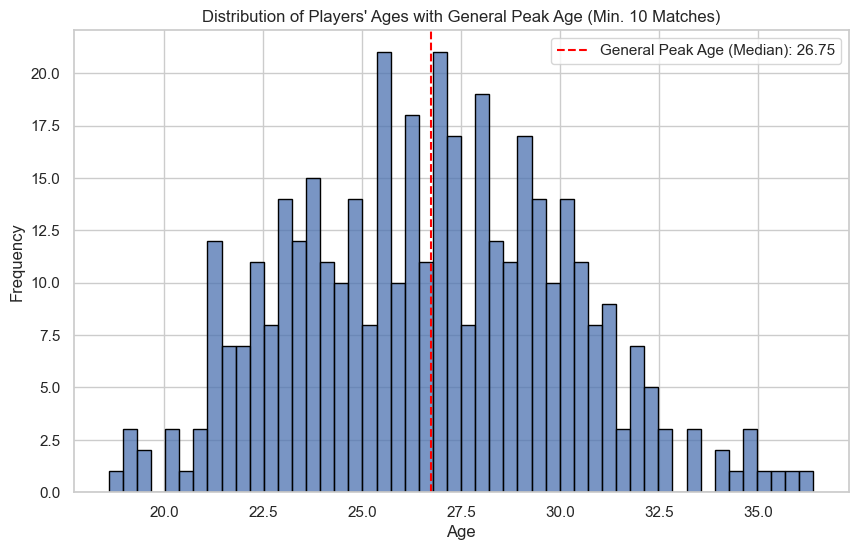

In [23]:
# Define the training data range
training_data_filter = (df['year'] >= 2009) & (df['year'] <= 2020)

# Extracting player 1 and player 2 information for training data
player1_df = df[training_data_filter][['p1_id', 'p1_name', 'p1_age', 'p1_rankpt']].copy()
player1_df.columns = ['player_id', 'player_name', 'player_age', 'player_rankpt']
player2_df = df[training_data_filter][['p2_id', 'p2_name', 'p2_age', 'p2_rankpt']].copy()
player2_df.columns = ['player_id', 'player_name', 'player_age', 'player_rankpt']

# Concatenating player 1 and player 2 data
all_players_df = pd.concat([player1_df, player2_df], ignore_index=True)

# Filtering players with at least 10 matches
players_with_min_matches = all_players_df['player_id'].value_counts() >= 10
eligible_players = players_with_min_matches.index[players_with_min_matches]
all_players_df = all_players_df[all_players_df['player_id'].isin(eligible_players)]

# Grouping by player ID and getting the age corresponding to the maximum rank points (peak ages for each player)
peak_performance_df = all_players_df.loc[all_players_df.groupby('player_id')['player_rankpt'].idxmax()]

# Calculating the median and mean of the peak ages
median_peak_age = peak_performance_df['player_age'].median()
mean_peak_age = peak_performance_df['player_age'].mean()

# Decide which to use: median or mean (using median in this example)
general_peak_age = median_peak_age

# Creating columns to represent the difference between each player's current age and the general peak age
df['p1_diff_from_peak_age'] = (df['p1_age'] - general_peak_age).abs()
df['p2_diff_from_peak_age'] = (df['p2_age'] - general_peak_age).abs()

# Creating a new feature representing the difference between the two players' differences from the general peak age
df['diff_ageGeneralPeak'] = df['p1_diff_from_peak_age'] - df['p2_diff_from_peak_age']

# Drop the temporary diff_from_peak_age columns
df.drop(columns=['p1_diff_from_peak_age', 'p2_diff_from_peak_age'], inplace=True)

show_favorite_win_rate('diff_ageGeneralPeak')
plot_histogram(df['diff_ageGeneralPeak'], bins=50, kde=False)

# Visualizing the distribution of peak ages (now with vertical lines representing the general peak ages)
plt.figure(figsize=(10, 6))
sns.histplot(peak_performance_df['player_age'], bins=50, kde=False, edgecolor='black')
#plt.axvline(mean_peak_age, color='green', linestyle='-.', label=f'General Peak Age (Mean): {mean_peak_age}')
plt.axvline(median_peak_age, color='red', linestyle='--', label=f'General Peak Age (Median): {median_peak_age}')
plt.title("Distribution of Players' Ages with General Peak Age (Min. 10 Matches)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.show()


##### Games-Based Fatigue Difference #####

In [24]:
%%script echo skipped
### GRID SEARCH ###
# Function to calculate fatigue for a specific player with time discount factor
def calculate_fatigue(player_id, player_data, start_date, end_date, discount_period, discount_factor):
    fatigue_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        fatigue = row['total_games']
        fatigue_sum += weight * fatigue
        total_weight += weight

    return (fatigue_sum, total_weight) if not player_data.empty else (None, None)

# Function to calculate the difference in fatigue for a match
def calculate_games_fatigue_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    p1_fatigue, p1_total_weight = calculate_fatigue(row['p1_id'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_fatigue, p2_total_weight = calculate_fatigue(row['p2_id'], p2_data, start_date, end_date, discount_period, discount_factor)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_fatigue, p2_fatigue, uncertainty_threshold)

# Define ranges for the parameters
time_frame_range = [5]
common_opponents_range = [False]
discount_period_range = [1]
discount_factor_range = [0.99]
uncertainty_threshold_range = [2]

# Create a DataFrame to store results
results = []

# Iterate over all combinations of parameters
total_iterations = len(time_frame_range) * len(common_opponents_range) * len(discount_period_range) * len(discount_factor_range) * len(uncertainty_threshold_range)
current_iteration = 1

for time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold in product(
        time_frame_range, common_opponents_range, discount_period_range, discount_factor_range, uncertainty_threshold_range):
    
    # Calculate the feature with the current set of parameters
    df['diff_gamesFatigue'] = df.apply(lambda row: calculate_games_fatigue_difference(
        row, 
        time_frame=time_frame, 
        common_opponents=common_opponents, 
        discount_period=discount_period, 
        discount_factor=discount_factor, 
        uncertainty_threshold=uncertainty_threshold), 
        axis=1)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Prepare the feature
    X = df[['diff_gamesFatigue']].fillna(0)

    # Scale the feature to [0, 1]
    X_scaled = scaler.fit_transform(X)

    # Prepare the target
    y = df['p1_won']

    # Calculate chi-square score for the feature
    chi2_score, p_values = chi2(X_scaled, y)

    # Append the results
    results.append({
        'common_opponents': common_opponents,
        'discount_period': discount_period,
        'discount_factor': discount_factor,
        'time_frame': time_frame,
        'uncertainty_threshold': uncertainty_threshold,
        'Chi2_Score': chi2_score[0],
        'P_Value': p_values[0]
    })

    # Drop the column to prepare for the next iteration
    df.drop('diff_gamesFatigue', axis=1, inplace=True)

    # Display the results
    clear_output(wait=True)
    results_df = pd.DataFrame(results)
    sorted_results = results_df.sort_values(by='Chi2_Score', ascending=False)
    display(sorted_results.head(200))

    # Print progress update
    print(f"Completed iteration {current_iteration}/{total_iterations} at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    current_iteration += 1

# Export sorted results to a CSV file inside the '_fe' folder
sorted_results.to_csv('_fe/diff_gamesFatigue.csv', index=False)


skipped


,Win Counts,Total Counts,Favorite's Win Rate
diff_gamesFatigue,,,
0.00,12660,19576,64.67
1.96,69,99,69.70
-0.98,71,96,73.96
-1.96,55,82,67.07
0.98,55,79,69.62
...,...,...,...
-8.35,0,1,0.00
-8.33,0,1,0.00
-8.33,0,1,0.00


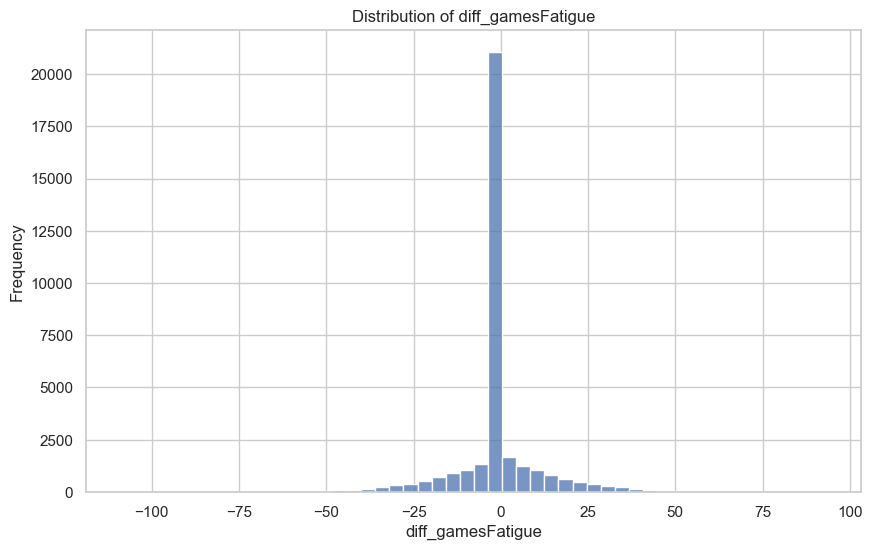

In [25]:
# Function to calculate fatigue for a specific player with time discount factor
def calculate_fatigue(player_id, player_data, start_date, end_date, discount_period, discount_factor):
    fatigue_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        fatigue = row['total_games']
        fatigue_sum += weight * fatigue
        total_weight += weight

    return (fatigue_sum, total_weight) if not player_data.empty else (None, None)

# Function to calculate the difference in fatigue for a match
def calculate_games_fatigue_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    p1_fatigue, p1_total_weight = calculate_fatigue(row['p1_id'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_fatigue, p2_total_weight = calculate_fatigue(row['p2_id'], p2_data, start_date, end_date, discount_period, discount_factor)

    # # For debugging
    # display(p1_data[['p1_id', 'p2_id', 'p1_won', 'total_games', 'match_date']].sort_values(by=['p1_id', 'match_date']))
    # p1_data[['p1_id', 'p2_id', 'p1_won', 'total_games', 'match_date']].sort_values(by=['p1_id', 'match_date']).to_clipboard()
    # display(p2_data[['p1_id', 'p2_id', 'p1_won', 'total_games', 'match_date']].sort_values(by=['p2_id', 'match_date']))
    # p2_data[['p1_id', 'p2_id', 'p1_won', 'total_games', 'match_date']].sort_values(by=['p2_id', 'match_date']).to_clipboard()
    # print(end_date)
    # print(p1_fatigue, p2_fatigue)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_fatigue, p2_fatigue, uncertainty_threshold)

# Apply the difference in fatigue calculation to the dataframe
df['diff_gamesFatigue'] = df.apply(lambda row: calculate_games_fatigue_difference(
    row, time_frame=5, common_opponents=False, discount_period=1, discount_factor=0.99, uncertainty_threshold=10), axis=1)

show_favorite_win_rate('diff_gamesFatigue')
plot_histogram(df['diff_gamesFatigue'], bins=50, kde=False)

# # For debugging
# calculate_games_fatigue_difference(
#     row=df[df['match_id'] == '2022-0605-0300'].iloc[0], 
#     time_frame=5, 
#     common_opponents=False, 
#     discount_period=1, 
#     discount_factor=1, 
#     uncertainty_threshold=1
# )


##### Rank Momentum (log-scale) Difference #####

In [26]:
%%script echo skipped
### GRID SEARCH ###
# Function to calculate rank momentum for a player with time discount factor
def calculate_rank_momentum(player_id, current_rank, player_data, start_date, end_date, discount_period, discount_factor):
    rank_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        rank = row['p1_rank'] if player_id == row['p1_id'] else row['p2_rank']
        rank_sum += weight * rank
        total_weight += weight

    avg_rank = rank_sum / total_weight if total_weight else current_rank
    rank_momentum_log = np.log10(avg_rank / current_rank) if current_rank != 0 else 0

    return (rank_momentum_log, total_weight) if not player_data.empty else (None, None)

# Function to calculate the difference in rank momentum for a match
def calculate_rank_momentum_log_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    p1_rank_momentum_log, p1_total_weight = calculate_rank_momentum(row['p1_id'], row['p1_rank'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_rank_momentum_log, p2_total_weight = calculate_rank_momentum(row['p2_id'], row['p2_rank'], p2_data, start_date, end_date, discount_period, discount_factor)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_rank_momentum_log, p2_rank_momentum_log, uncertainty_threshold)

# Define ranges for the parameters
time_frame_range = [365*2]
common_opponents_range = [False]
discount_period_range = [90]
discount_factor_range = [0.99]
uncertainty_threshold_range = [1]

# Create a DataFrame to store results
results = []

# Iterate over all combinations of parameters
total_iterations = len(time_frame_range) * len(common_opponents_range) * len(discount_period_range) * len(discount_factor_range) * len(uncertainty_threshold_range)
current_iteration = 1

for time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold in product(
        time_frame_range, common_opponents_range, discount_period_range, discount_factor_range, uncertainty_threshold_range):
    
    # Calculate the feature with the current set of parameters
    df['diff_rankMomentum_log'] = df.apply(lambda row: calculate_rank_momentum_log_difference(
        row, 
        time_frame=time_frame, 
        common_opponents=common_opponents, 
        discount_period=discount_period, 
        discount_factor=discount_factor, 
        uncertainty_threshold=uncertainty_threshold), 
        axis=1)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Prepare the feature
    X = df[['diff_rankMomentum_log']].fillna(0)

    # Scale the feature to [0, 1]
    X_scaled = scaler.fit_transform(X)

    # Prepare the target
    y = df['p1_won']

    # Calculate chi-square score for the feature
    chi2_score, p_values = chi2(X_scaled, y)

    # Append the results
    results.append({
        'common_opponents': common_opponents,
        'discount_period': discount_period,
        'discount_factor': discount_factor,
        'time_frame': time_frame,
        'uncertainty_threshold': uncertainty_threshold,
        'Chi2_Score': chi2_score[0],
        'P_Value': p_values[0]
    })

    # Drop the column to prepare for the next iteration
    df.drop('diff_rankMomentum_log', axis=1, inplace=True)

    # Display the results
    clear_output(wait=True)
    results_df = pd.DataFrame(results)
    sorted_results = results_df.sort_values(by='Chi2_Score', ascending=False)
    display(sorted_results.head(200))

    # Print progress update
    print(f"Completed iteration {current_iteration}/{total_iterations} at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    current_iteration += 1

# Export sorted results to a CSV file inside the '_fe' folder
sorted_results.to_csv('_fe/diff_rankMomentum_log.csv', index=False)


skipped


,Win Counts,Total Counts,Favorite's Win Rate
diff_rankMomentum_log,,,
0.00,848,1115,76.05
0.00,5,9,55.56
-0.00,4,5,80.00
-0.00,3,3,100.00
-0.00,2,3,66.67
...,...,...,...
-0.11,0,1,0.00
-0.11,1,1,100.00
-0.11,1,1,100.00


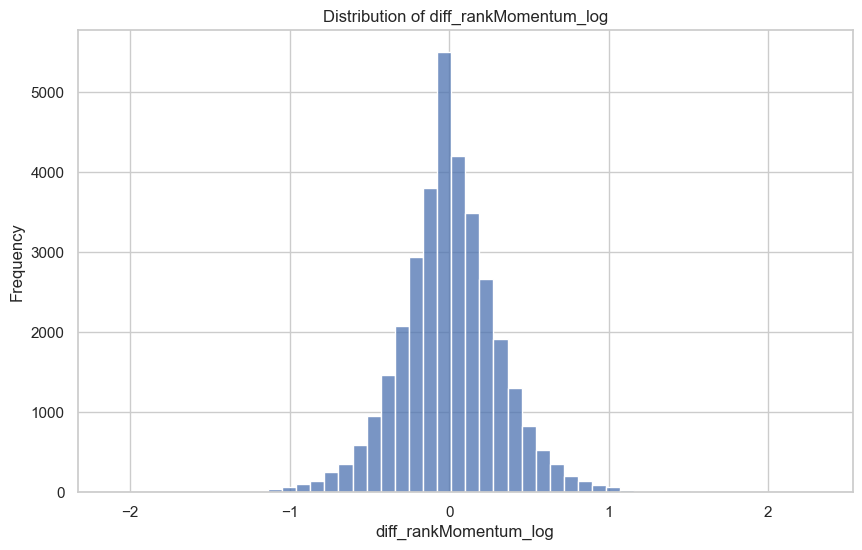

In [27]:
# Function to calculate rank momentum for a player with time discount factor
def calculate_rank_momentum(player_id, current_rank, player_data, start_date, end_date, discount_period, discount_factor):
    rank_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        rank = row['p1_rank'] if player_id == row['p1_id'] else row['p2_rank']
        rank_sum += weight * rank
        total_weight += weight

    avg_rank = rank_sum / total_weight if total_weight else current_rank
    rank_momentum_log = np.log10(avg_rank / current_rank) if current_rank != 0 else 0

    return (rank_momentum_log, total_weight) if not player_data.empty else (None, None)

# Function to calculate the difference in rank momentum for a match
def calculate_rank_momentum_log_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    p1_rank_momentum_log, p1_total_weight = calculate_rank_momentum(row['p1_id'], row['p1_rank'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_rank_momentum_log, p2_total_weight = calculate_rank_momentum(row['p2_id'], row['p2_rank'], p2_data, start_date, end_date, discount_period, discount_factor)

    # # For debugging
    # display(p1_data[['p1_id', 'p2_id', 'p1_rank', 'p2_rank', 'p1_won', 'match_date']].sort_values(by=['p1_id', 'match_date']))
    # p1_data[['p1_id', 'p2_id', 'p1_rank', 'p2_rank', 'p1_won', 'match_date']].sort_values(by=['p1_id', 'match_date']).to_clipboard()
    # display(p2_data[['p1_id', 'p2_id', 'p1_rank', 'p2_rank', 'p1_won', 'match_date']].sort_values(by=['p2_id', 'match_date']))
    # p2_data[['p1_id', 'p2_id', 'p1_rank', 'p2_rank', 'p1_won', 'match_date']].sort_values(by=['p2_id', 'match_date']).to_clipboard()
    # print(row['p1_rank'], row['p2_rank'])
    # print(p1_rank_momentum_log, p2_rank_momentum_log)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_rank_momentum_log, p2_rank_momentum_log, uncertainty_threshold)

# Apply the difference in rank momentum calculation to the dataframe
df['diff_rankMomentum_log'] = df.apply(lambda row: calculate_rank_momentum_log_difference(
    row, time_frame=365*2, common_opponents=False, discount_period=90, discount_factor=0.99, uncertainty_threshold=1), axis=1)

show_favorite_win_rate('diff_rankMomentum_log')
plot_histogram(df['diff_rankMomentum_log'], bins=50, kde=False)

# # For debugging
# calculate_rank_momentum_log_difference(
#     row=df[df['match_id'] == '2022-0605-0300'].iloc[0], 
#     time_frame=183, 
#     common_opponents=False, 
#     discount_period=61, 
#     discount_factor=1, 
#     uncertainty_threshold=1
# )


##### Rankpt Momentum (log-scale) Difference #####

In [28]:
%%script echo skipped
### GRID SEARCH ###
# Function to calculate rankpt momentum for a player with time discount factor
def calculate_rankpt_momentum(player_id, current_rankpt, player_data, start_date, end_date, discount_period, discount_factor):
    rankpt_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        rankpt = row['p1_rankpt'] if player_id == row['p1_id'] else row['p2_rankpt']
        rankpt_sum += weight * rankpt
        total_weight += weight

    avg_rankpt = rankpt_sum / total_weight if total_weight else current_rankpt
    rankpt_momentum_log = np.log10(avg_rankpt / current_rankpt) if current_rankpt != 0 else 0

    # replace inf with 0
    if np.isinf(rankpt_momentum_log):
        rankpt_momentum_log = 0

    return (rankpt_momentum_log, total_weight) if not player_data.empty else (None, None)

# Function to calculate the difference in rankpt momentum for a match
def calculate_rankpt_momentum_log_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    p1_rankpt_momentum_log, p1_total_weight = calculate_rankpt_momentum(row['p1_id'], row['p1_rankpt'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_rankpt_momentum_log, p2_total_weight = calculate_rankpt_momentum(row['p2_id'], row['p2_rankpt'], p2_data, start_date, end_date, discount_period, discount_factor)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_rankpt_momentum_log, p2_rankpt_momentum_log, uncertainty_threshold)

# Define ranges for the parameters
time_frame_range = [365]
common_opponents_range = [False]
discount_period_range = [30]
discount_factor_range = [0.80]
uncertainty_threshold_range = [1]

# Create a DataFrame to store results
results = []

# Iterate over all combinations of parameters
total_iterations = len(time_frame_range) * len(common_opponents_range) * len(discount_period_range) * len(discount_factor_range) * len(uncertainty_threshold_range)
current_iteration = 1

for time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold in product(
        time_frame_range, common_opponents_range, discount_period_range, discount_factor_range, uncertainty_threshold_range):

    # Calculate the feature with the current set of parameters
    df['diff_rankptMomentum_log'] = df.apply(lambda row: calculate_rankpt_momentum_log_difference(
        row, 
        time_frame=time_frame, 
        common_opponents=common_opponents, 
        discount_period=discount_period, 
        discount_factor=discount_factor, 
        uncertainty_threshold=uncertainty_threshold), 
        axis=1)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Prepare the feature
    X = df[['diff_rankptMomentum_log']].fillna(0)

    # Scale the feature to [0, 1]
    X_scaled = scaler.fit_transform(X)

    # Prepare the target
    y = df['p1_won']

    # Calculate chi-square score for the feature
    chi2_score, p_values = chi2(X_scaled, y)

    # Append the results
    results.append({
        'common_opponents': common_opponents,
        'discount_period': discount_period,
        'discount_factor': discount_factor,
        'time_frame': time_frame,
        'uncertainty_threshold': uncertainty_threshold,
        'Chi2_Score': chi2_score[0],
        'P_Value': p_values[0]
    })

    # Drop the column to prepare for the next iteration
    df.drop('diff_rankptMomentum_log', axis=1, inplace=True)

    # Display the results
    clear_output(wait=True)
    results_df = pd.DataFrame(results)
    sorted_results = results_df.sort_values(by='Chi2_Score', ascending=False)
    display(sorted_results.head(200))

    # Print progress update
    print(f"Completed iteration {current_iteration}/{total_iterations} at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    current_iteration += 1

# Export sorted results to a CSV file inside the '_fe' folder
sorted_results.to_csv('_fe/diff_rankptMomentum_log.csv', index=False)


skipped


,Win Counts,Total Counts,Favorite's Win Rate
diff_rankptMomentum_log,,,
0.00,1252,1745,71.75
-0.00,4,9,44.44
0.00,6,7,85.71
-0.00,3,4,75.00
0.04,0,1,0.00
...,...,...,...
-0.04,1,1,100.00
-0.04,1,1,100.00
-0.04,1,1,100.00


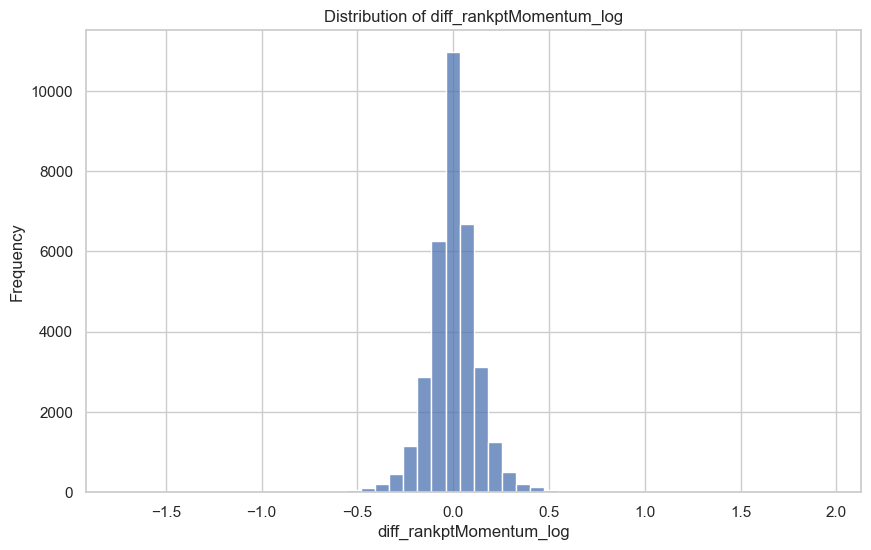

In [29]:
# Function to calculate rankpt momentum for a player with time discount factor
def calculate_rankpt_momentum(player_id, current_rankpt, player_data, start_date, end_date, discount_period, discount_factor):
    rankpt_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        rankpt = row['p1_rankpt'] if player_id == row['p1_id'] else row['p2_rankpt']
        rankpt_sum += weight * rankpt
        total_weight += weight

    avg_rankpt = rankpt_sum / total_weight if total_weight else current_rankpt
    rankpt_momentum_log = np.log10(avg_rankpt / current_rankpt) if current_rankpt != 0 else 0

    # replace inf with 0
    if np.isinf(rankpt_momentum_log):
        rankpt_momentum_log = 0

    return (rankpt_momentum_log, total_weight) if not player_data.empty else (None, None)

# Function to calculate the difference in rankpt momentum for a match
def calculate_rankpt_momentum_log_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    p1_rankpt_momentum_log, p1_total_weight = calculate_rankpt_momentum(row['p1_id'], row['p1_rankpt'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_rankpt_momentum_log, p2_total_weight = calculate_rankpt_momentum(row['p2_id'], row['p2_rankpt'], p2_data, start_date, end_date, discount_period, discount_factor)

    # # For debugging
    # display(p1_data[['p1_id', 'p2_id', 'p1_rankpt', 'p2_rankpt', 'p1_won', 'match_date']].sort_values(by=['p1_id', 'match_date']))
    # p1_data[['p1_id', 'p2_id', 'p1_rankpt', 'p2_rankpt', 'p1_won', 'match_date']].sort_values(by=['p1_id', 'match_date']).to_clipboard()
    # display(p2_data[['p1_id', 'p2_id', 'p1_rankpt', 'p2_rankpt', 'p1_won', 'match_date']].sort_values(by=['p2_id', 'match_date']))
    # p2_data[['p1_id', 'p2_id', 'p1_rankpt', 'p2_rankpt', 'p1_won', 'match_date']].sort_values(by=['p2_id', 'match_date']).to_clipboard()
    # print(row['p1_rankpt'], row['p2_rankpt'])
    # print(p1_rankpt_momentum_log, p2_rankpt_momentum_log)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_rankpt_momentum_log, p2_rankpt_momentum_log, uncertainty_threshold)

# Apply the difference in rankpt momentum calculation to the dataframe
df['diff_rankptMomentum_log'] = df.apply(lambda row: calculate_rankpt_momentum_log_difference(
    row, time_frame=365, common_opponents=False, discount_period=30, discount_factor=0.8, uncertainty_threshold=1), axis=1)

show_favorite_win_rate('diff_rankptMomentum_log')
plot_histogram(df['diff_rankptMomentum_log'], bins=50, kde=False)

# # For debugging
# calculate_rankpt_momentum_log_difference(
#     row=df[df['match_id'] == '2022-0605-0300'].iloc[0], 
#     time_frame=183, 
#     common_opponents=False, 
#     discount_period=61, 
#     discount_factor=1, 
#     uncertainty_threshold=1
# )


##### Average Match Duration Difference #####

In [30]:
%%script echo skipped
### GRID SEARCH ###
# Function to calculate the average match duration for a player with time discount factor
def calculate_avg_duration(player_id, player_data, start_date, end_date, discount_period, discount_factor):
    duration_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        duration_sum += weight * row['minutes']
        total_weight += weight
    
    avg_duration = duration_sum / total_weight if total_weight else None

    return (avg_duration, total_weight) if not player_data.empty else (None, None)

# Function to calculate the difference in average match durations for a match
def calculate_avg_duration_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    p1_avg_duration, p1_total_weight = calculate_avg_duration(row['p1_id'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_avg_duration, p2_total_weight = calculate_avg_duration(row['p2_id'], p2_data, start_date, end_date, discount_period, discount_factor)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_avg_duration, p2_avg_duration, uncertainty_threshold)

# Define ranges for the parameters
time_frame_range = [365*20]
common_opponents_range = [False]
discount_period_range = [90]
discount_factor_range = [0.80]
uncertainty_threshold_range = [1]

# Create a DataFrame to store results
results = []

# Iterate over all combinations of parameters
total_iterations = len(time_frame_range) * len(common_opponents_range) * len(discount_period_range) * len(discount_factor_range) * len(uncertainty_threshold_range)
current_iteration = 1

for time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold in product(
        time_frame_range, common_opponents_range, discount_period_range, discount_factor_range, uncertainty_threshold_range):

    # Calculate the feature with the current set of parameters
    df['diff_avgDuration'] = df.apply(lambda row: calculate_avg_duration_difference(
        row, 
        time_frame=time_frame, 
        common_opponents=common_opponents, 
        discount_period=discount_period, 
        discount_factor=discount_factor, 
        uncertainty_threshold=uncertainty_threshold), 
        axis=1)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Prepare the feature
    X = df[['diff_avgDuration']].fillna(0)

    # Scale the feature to [0, 1]
    X_scaled = scaler.fit_transform(X)

    # Prepare the target
    y = df['p1_won']

    # Calculate chi-square score for the feature
    chi2_score, p_values = chi2(X_scaled, y)

    # Append the results
    results.append({
        'common_opponents': common_opponents,
        'discount_period': discount_period,
        'discount_factor': discount_factor,
        'time_frame': time_frame,
        'uncertainty_threshold': uncertainty_threshold,
        'Chi2_Score': chi2_score[0],
        'P_Value': p_values[0]
    })

    # Drop the column to prepare for the next iteration
    df.drop('diff_avgDuration', axis=1, inplace=True)

    # Display the results
    clear_output(wait=True)
    results_df = pd.DataFrame(results)
    sorted_results = results_df.sort_values(by='Chi2_Score', ascending=False)
    display(sorted_results.head(200))

    # Print progress update
    print(f"Completed iteration {current_iteration}/{total_iterations} at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    current_iteration += 1

# Export sorted results to a CSV file inside the '_fe' folder
sorted_results.to_csv('_fe/diff_avgDuration.csv', index=False)


skipped


,Win Counts,Total Counts,Favorite's Win Rate
diff_avgDuration,,,
0.00,739,970,76.19
-11.75,1,3,33.33
10.00,1,2,50.00
13.33,1,2,50.00
-16.33,1,2,50.00
...,...,...,...
-5.00,0,1,0.00
-5.00,1,1,100.00
-5.00,0,1,0.00


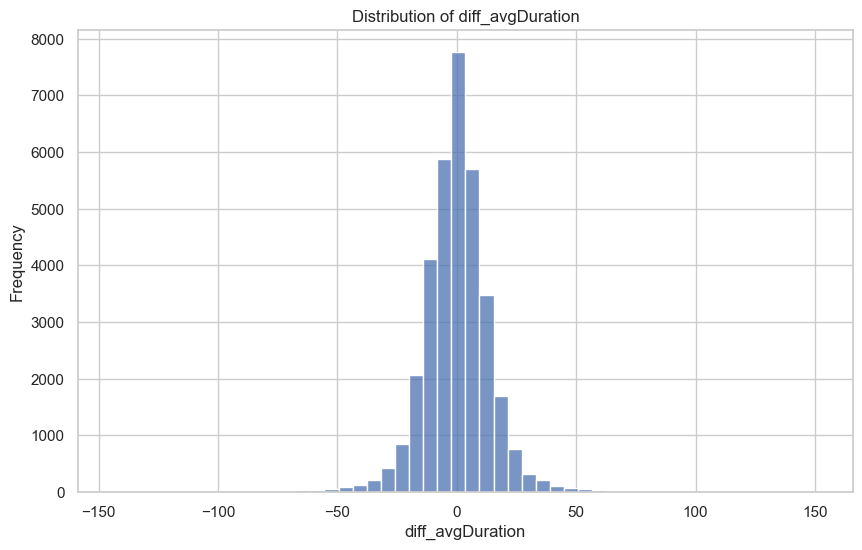

In [31]:
# Function to calculate the average match duration for a player with time discount factor
def calculate_avg_duration(player_id, player_data, start_date, end_date, discount_period, discount_factor):
    duration_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        duration_sum += weight * row['minutes']
        total_weight += weight
    
    avg_duration = duration_sum / total_weight if total_weight else None

    return (avg_duration, total_weight) if not player_data.empty else (None, None)

# Function to calculate the difference in average match durations for a match
def calculate_avg_duration_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    p1_avg_duration, p1_total_weight = calculate_avg_duration(row['p1_id'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_avg_duration, p2_total_weight = calculate_avg_duration(row['p2_id'], p2_data, start_date, end_date, discount_period, discount_factor)

    # # For debugging
    # display(p1_data[['p1_id', 'p2_id', 'p1_won', 'minutes', 'match_date']].sort_values(by=['p1_id', 'match_date']))
    # p1_data[['p1_id', 'p2_id', 'p1_won', 'minutes', 'match_date']].sort_values(by=['p1_id', 'match_date']).to_clipboard()
    # display(p2_data[['p1_id', 'p2_id', 'p1_won', 'minutes', 'match_date']].sort_values(by=['p2_id', 'match_date']))
    # p2_data[['p1_id', 'p2_id', 'p1_won', 'minutes', 'match_date']].sort_values(by=['p2_id', 'match_date']).to_clipboard()
    # print(p1_avg_duration, p2_avg_duration)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_avg_duration, p2_avg_duration, uncertainty_threshold)

# Apply the difference in average match durations calculation to the dataframe
df['diff_avgDuration'] = df.apply(lambda row: calculate_avg_duration_difference(
    row, time_frame=365*20, common_opponents=False, discount_period=90, discount_factor=0.8, uncertainty_threshold=1), axis=1)

show_favorite_win_rate('diff_avgDuration')
plot_histogram(df['diff_avgDuration'], bins=50, kde=False)

# # For debugging
# calculate_avg_duration_difference(
#     row=df[df['match_id'] == '2022-0605-0300'].iloc[0], 
#     time_frame=365*20, 
#     common_opponents=True, 
#     discount_period=365, 
#     discount_factor=1, 
#     uncertainty_threshold=1
# )


##### Surface Advantage Difference #####

In [32]:
%%script echo skipped
### GRID SEARCH ###
# Function to identify the preferred surface for each player with time discount factor
def calculate_surface_win_ratios(player_id, player_data, start_date, end_date, discount_period, discount_factor):
    surface_win_sum = defaultdict(float)
    surface_total_weight = defaultdict(float)
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        surface = row['surface']
        result = row['p1_won'] if player_id == row['p1_id'] else 1 - row['p1_won']
        surface_win_sum[surface] += weight * result
        surface_total_weight[surface] += weight
    
    surface_win_ratios = {surface: win_sum / total_weight for surface, win_sum, total_weight in zip(surface_win_sum.keys(), surface_win_sum.values(), surface_total_weight.values())}
    
    return (surface_win_ratios, surface_total_weight) if not player_data.empty else (None, None)

# Function to calculate surface advantage for a match
def calculate_surface_advantage(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    p1_win_ratios, p1_total_weight = calculate_surface_win_ratios(row['p1_id'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_win_ratios, p2_total_weight = calculate_surface_win_ratios(row['p2_id'], p2_data, start_date, end_date, discount_period, discount_factor)

    if p1_win_ratios is None or p2_win_ratios is None:
        return 0
    
    match_surface = row['surface']
    p1_preferred_surface = max(p1_win_ratios, key=p1_win_ratios.get)
    p2_preferred_surface = max(p2_win_ratios, key=p2_win_ratios.get)

    uncertainty = 1 / (sum(p1_total_weight.values()) * sum(p2_total_weight.values()))
    if uncertainty >= uncertainty_threshold:
        return 0
    
    advantage = 0
    if p1_preferred_surface == match_surface:
        advantage += 1
    if p2_preferred_surface == match_surface:
        advantage -= 1
    return advantage

# Define ranges for the parameters
time_frame_range = [365]
common_opponents_range = [False]
discount_period_range = [30]
discount_factor_range = [0.60]
uncertainty_threshold_range = [1]

# Create a DataFrame to store results
results = []

# Iterate over all combinations of parameters
total_iterations = len(time_frame_range) * len(common_opponents_range) * len(discount_period_range) * len(discount_factor_range) * len(uncertainty_threshold_range)
current_iteration = 1

for time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold in product(
        time_frame_range, common_opponents_range, discount_period_range, discount_factor_range, uncertainty_threshold_range):

    # Calculate the feature with the current set of parameters
    df['diff_surfaceAdvantage'] = df.apply(lambda row: calculate_surface_advantage(
        row, 
        time_frame=time_frame, 
        common_opponents=common_opponents, 
        discount_period=discount_period, 
        discount_factor=discount_factor, 
        uncertainty_threshold=uncertainty_threshold), 
        axis=1)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Prepare the feature
    X = df[['diff_surfaceAdvantage']].fillna(0)

    # Scale the feature to [0, 1]
    X_scaled = scaler.fit_transform(X)

    # Prepare the target
    y = df['p1_won']

    # Calculate chi-square score for the feature
    chi2_score, p_values = chi2(X_scaled, y)

    # Append the results
    results.append({
        'common_opponents': common_opponents,
        'discount_period': discount_period,
        'discount_factor': discount_factor,
        'time_frame': time_frame,
        'uncertainty_threshold': uncertainty_threshold,
        'Chi2_Score': chi2_score[0],
        'P_Value': p_values[0]
    })

    # Drop the column to prepare for the next iteration
    df.drop('diff_surfaceAdvantage', axis=1, inplace=True)

    # Display the results
    clear_output(wait=True)
    results_df = pd.DataFrame(results)
    sorted_results = results_df.sort_values(by='Chi2_Score', ascending=False)
    display(sorted_results.head(200))

    # Print progress update
    print(f"Completed iteration {current_iteration}/{total_iterations} at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    current_iteration += 1

# Export sorted results to a CSV file inside the '_fe' folder
sorted_results.to_csv('_fe/diff_surfaceAdvantage.csv', index=False)


skipped


,Win Counts,Total Counts,Favorite's Win Rate
diff_surfaceAdvantage,,,
0,13676,20736,65.95
1,4471,6761,66.13
-1,4363,6624,65.87


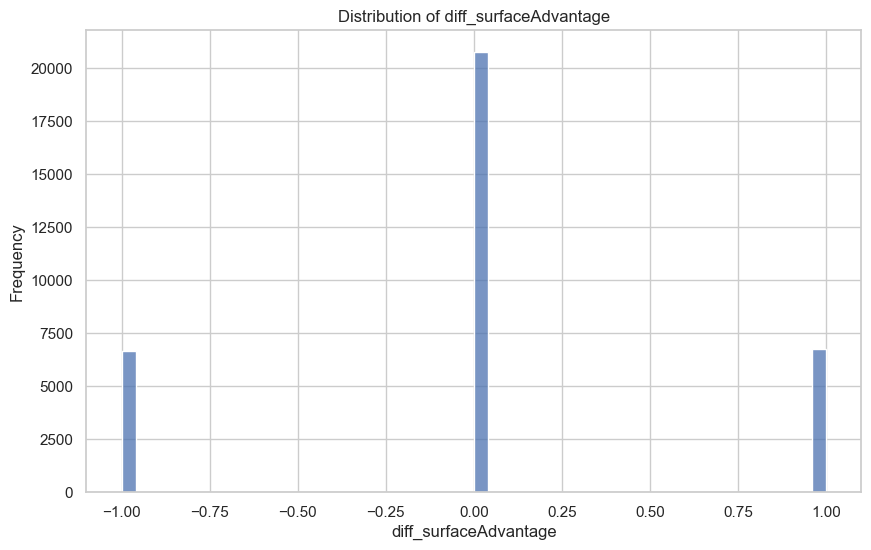

In [33]:
# Function to identify the preferred surface for each player with time discount factor
def calculate_surface_win_ratios(player_id, player_data, start_date, end_date, discount_period, discount_factor):
    surface_win_sum = defaultdict(float)
    surface_total_weight = defaultdict(float)
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        surface = row['surface']
        result = row['p1_won'] if player_id == row['p1_id'] else 1 - row['p1_won']
        surface_win_sum[surface] += weight * result
        surface_total_weight[surface] += weight
    
    surface_win_ratios = {surface: win_sum / total_weight for surface, win_sum, total_weight in zip(surface_win_sum.keys(), surface_win_sum.values(), surface_total_weight.values())}
    
    return (surface_win_ratios, surface_total_weight) if not player_data.empty else (None, None)

# Function to calculate surface advantage for a match
def calculate_surface_advantage(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    p1_win_ratios, p1_total_weight = calculate_surface_win_ratios(row['p1_id'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_win_ratios, p2_total_weight = calculate_surface_win_ratios(row['p2_id'], p2_data, start_date, end_date, discount_period, discount_factor)

    if p1_win_ratios is None or p2_win_ratios is None:
        return 0
    
    match_surface = row['surface']
    p1_preferred_surface = max(p1_win_ratios, key=p1_win_ratios.get)
    p2_preferred_surface = max(p2_win_ratios, key=p2_win_ratios.get)

    # # For debugging
    # display(p1_data[['p1_id', 'p2_id', 'p1_won', 'surface', 'match_date']].sort_values(by=['p1_id', 'match_date']))
    # p1_data[['p1_id', 'p2_id', 'p1_won', 'surface', 'match_date']].sort_values(by=['p1_id', 'match_date']).to_clipboard()
    # display(p2_data[['p1_id', 'p2_id', 'p1_won', 'surface', 'match_date']].sort_values(by=['p2_id', 'match_date']))
    # p2_data[['p1_id', 'p2_id', 'p1_won', 'surface', 'match_date']].sort_values(by=['p2_id', 'match_date']).to_clipboard()
    # print(match_surface) 
    # print(p1_preferred_surface, p1_win_ratios)
    # print(p2_preferred_surface, p2_win_ratios)

    uncertainty = 1 / (sum(p1_total_weight.values()) * sum(p2_total_weight.values()))
    if uncertainty >= uncertainty_threshold:
        return 0
    
    advantage = 0
    if p1_preferred_surface == match_surface:
        advantage += 1
    if p2_preferred_surface == match_surface:
        advantage -= 1
    return advantage

# Apply the surface advantage calculation to the dataframe
df['diff_surfaceAdvantage'] = df.apply(lambda row: calculate_surface_advantage(
    row, time_frame=365, common_opponents=False, discount_period=30, discount_factor=0.6, uncertainty_threshold=1), axis=1)

show_favorite_win_rate('diff_surfaceAdvantage')
plot_histogram(df['diff_surfaceAdvantage'], bins=50, kde=False)

# # For debugging
# calculate_surface_advantage(
#     row=df[df['match_id'] == '2022-0439-0300'].iloc[0], 
#     time_frame=365*20, 
#     common_opponents=True, 
#     discount_period=365, 
#     discount_factor=1, 
#     uncertainty_threshold=1
# )


##### Surface Win Ratio Difference #####

In [34]:
%%script echo skipped
### GRID SEARCH ###
# Function to calculate the win ratio for a player utilizing time discount factor
def calculate_win_ratio(player_id, player_data, start_date, end_date, discount_period, discount_factor):
    win_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        result = row['p1_won'] if player_id == row['p1_id'] else 1 - row['p1_won']
        win_sum += weight * result
        total_weight += weight
    
    win_ratio = win_sum / total_weight if total_weight else 0.50
    
    return (win_ratio, total_weight) if not player_data.empty else (None, None)

# Function to calculate surface win ratio difference for a match
def calculate_surface_win_ratio_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']
    match_surface = row['surface']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name, match_surface)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name, match_surface)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    p1_win_ratio, p1_total_weight = calculate_win_ratio(row['p1_id'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_win_ratio, p2_total_weight = calculate_win_ratio(row['p2_id'], p2_data, start_date, end_date, discount_period, discount_factor)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_win_ratio, p2_win_ratio, uncertainty_threshold)

# Define ranges for the parameters
time_frame_range = [365*3]
common_opponents_range = [True]
discount_period_range = [365]
discount_factor_range = [1]
uncertainty_threshold_range = [5]

# Create a DataFrame to store results
results = []

# Iterate over all combinations of parameters
total_iterations = len(time_frame_range) * len(common_opponents_range) * len(discount_period_range) * len(discount_factor_range) * len(uncertainty_threshold_range)
current_iteration = 1

for time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold in product(
        time_frame_range, common_opponents_range, discount_period_range, discount_factor_range, uncertainty_threshold_range):
    
    # Calculate the feature with the current set of parameters
    df['diff_surfaceWinRatio'] = df.apply(lambda row: calculate_surface_win_ratio_difference(
        row, 
        time_frame=time_frame, 
        common_opponents=common_opponents, 
        discount_period=discount_period, 
        discount_factor=discount_factor, 
        uncertainty_threshold=uncertainty_threshold), 
        axis=1)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Prepare the feature
    X = df[['diff_surfaceWinRatio']].fillna(0)

    # Scale the feature to [0, 1]
    X_scaled = scaler.fit_transform(X)

    # Prepare the target
    y = df['p1_won']

    # Calculate chi-square score for the feature
    chi2_score, p_values = chi2(X_scaled, y)

    # Append the results
    results.append({
        'common_opponents': common_opponents,
        'discount_period': discount_period,
        'discount_factor': discount_factor,
        'time_frame': time_frame,
        'uncertainty_threshold': uncertainty_threshold,
        'Chi2_Score': chi2_score[0],
        'P_Value': p_values[0]
    })

    # Drop the column to prepare for the next iteration
    df.drop('diff_surfaceWinRatio', axis=1, inplace=True)

    # Display the results
    clear_output(wait=True)
    results_df = pd.DataFrame(results)
    sorted_results = results_df.sort_values(by='Chi2_Score', ascending=False)
    display(sorted_results.head(200))

    # Print progress update
    print(f"Completed iteration {current_iteration}/{total_iterations} at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    current_iteration += 1

# Export sorted results to a CSV file inside the '_fe' folder
sorted_results.to_csv('_fe/diff_surfaceWinRatio.csv', index=False)


skipped


,Win Counts,Total Counts,Favorite's Win Rate
diff_surfaceWinRatio,,,
0.00,7003,10716,65.35
-1.00,577,851,67.80
1.00,564,844,66.82
0.50,488,728,67.03
-0.50,500,706,70.82
...,...,...,...
-0.09,0,1,0.00
-0.09,1,1,100.00
-0.09,1,1,100.00


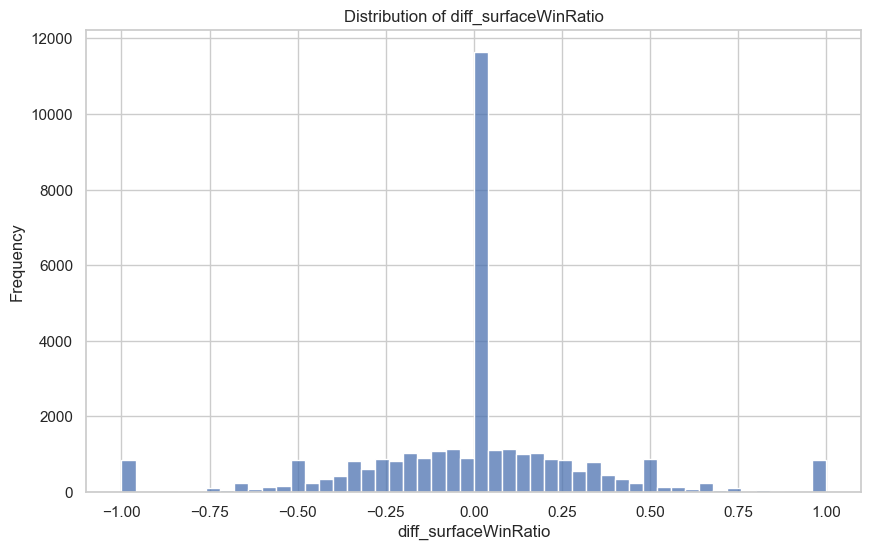

In [35]:
# Function to calculate the win ratio for a player utilizing time discount factor
def calculate_win_ratio(player_id, player_data, start_date, end_date, discount_period, discount_factor):
    win_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        result = row['p1_won'] if player_id == row['p1_id'] else 1 - row['p1_won']
        win_sum += weight * result
        total_weight += weight
    
    win_ratio = win_sum / total_weight if total_weight else 0.50
    
    return (win_ratio, total_weight) if not player_data.empty else (None, None)

# Function to calculate surface win ratio difference for a match
def calculate_surface_win_ratio_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']
    match_surface = row['surface']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name, match_surface)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name, match_surface)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    p1_win_ratio, p1_total_weight = calculate_win_ratio(row['p1_id'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_win_ratio, p2_total_weight = calculate_win_ratio(row['p2_id'], p2_data, start_date, end_date, discount_period, discount_factor)

    # # For debugging
    # display(p1_data[['p1_id', 'p2_id', 'p1_won', 'surface', 'match_date']].sort_values(by=['p1_id', 'match_date']))
    # p1_data[['p1_id', 'p2_id', 'p1_won', 'surface', 'match_date']].sort_values(by=['p1_id', 'match_date']).to_clipboard()
    # display(p2_data[['p1_id', 'p2_id', 'p1_won', 'surface', 'match_date']].sort_values(by=['p2_id', 'match_date']))
    # p2_data[['p1_id', 'p2_id', 'p1_won', 'surface', 'match_date']].sort_values(by=['p2_id', 'match_date']).to_clipboard()
    # print(p1_win_ratio, p2_win_ratio)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_win_ratio, p2_win_ratio, uncertainty_threshold)

# Apply the surface win ratio difference calculation to the dataframe
df['diff_surfaceWinRatio'] = df.apply(lambda row: calculate_surface_win_ratio_difference(
    row, time_frame=365*3, common_opponents=True, discount_period=365, discount_factor=1, uncertainty_threshold=5), axis=1)

show_favorite_win_rate('diff_surfaceWinRatio')
plot_histogram(df['diff_surfaceWinRatio'], bins=50, kde=False)

# # For debugging
# calculate_surface_win_ratio_difference(
#     row=df[df['match_id'] == '2022-0439-0300'].iloc[0], 
#     time_frame=365*20, 
#     common_opponents=True, 
#     discount_period=365, 
#     discount_factor=1, 
#     uncertainty_threshold=1
# )


##### Overall Win Ratio Difference #####

In [36]:
%%script echo skipped
### GRID SEARCH ###
# Function to calculate the overall win ratio for a player with time discount factor
def calculate_overall_win_ratio(player_id, player_data, start_date, end_date, discount_period, discount_factor):
    win_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        result = row['p1_won'] if player_id == row['p1_id'] else 1 - row['p1_won']
        win_sum += weight * result
        total_weight += weight

    win_ratio = win_sum / total_weight if total_weight else 0.50
        
    return (win_ratio, total_weight) if not player_data.empty else (None, None)

# Function to calculate overall win ratio difference for a match
def calculate_overall_win_ratio_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])  
    
    p1_win_ratio, p1_total_weight = calculate_overall_win_ratio(row['p1_id'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_win_ratio, p2_total_weight = calculate_overall_win_ratio(row['p2_id'], p2_data, start_date, end_date, discount_period, discount_factor)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_win_ratio, p2_win_ratio, uncertainty_threshold)

# Define ranges for the parameters
time_frame_range = [365]
common_opponents_range = [True]
discount_period_range = [365]
discount_factor_range = [0.95]
uncertainty_threshold_range = [5]

# Create a DataFrame to store results
results = []

# Iterate over all combinations of parameters
total_iterations = len(time_frame_range) * len(common_opponents_range) * len(discount_period_range) * len(discount_factor_range) * len(uncertainty_threshold_range)
current_iteration = 1

for time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold in product(
        time_frame_range, common_opponents_range, discount_period_range, discount_factor_range, uncertainty_threshold_range):
    
    # Calculate the feature with the current set of parameters
    df['diff_overallWinRatio'] = df.apply(lambda row: calculate_overall_win_ratio_difference(
        row, 
        time_frame=time_frame, 
        common_opponents=common_opponents, 
        discount_period=discount_period, 
        discount_factor=discount_factor, 
        uncertainty_threshold=uncertainty_threshold), 
        axis=1)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Prepare the feature
    X = df[['diff_overallWinRatio']].fillna(0)

    # Scale the feature to [0, 1]
    X_scaled = scaler.fit_transform(X)

    # Prepare the target
    y = df['p1_won']

    # Calculate chi-square score for the feature
    chi2_score, p_values = chi2(X_scaled, y)

    # Append the results
    results.append({
        'common_opponents': common_opponents,
        'discount_period': discount_period,
        'discount_factor': discount_factor,
        'time_frame': time_frame,
        'uncertainty_threshold': uncertainty_threshold,
        'Chi2_Score': chi2_score[0],
        'P_Value': p_values[0]
    })

    # Drop the column to prepare for the next iteration
    df.drop('diff_overallWinRatio', axis=1, inplace=True)

    # Display the results
    clear_output(wait=True)
    results_df = pd.DataFrame(results)
    sorted_results = results_df.sort_values(by='Chi2_Score', ascending=False)
    display(sorted_results.head(200))

    # Print progress update
    print(f"Completed iteration {current_iteration}/{total_iterations} at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    current_iteration += 1

# Export sorted results to a CSV file inside the '_fe' folder
sorted_results.to_csv('_fe/diff_overallWinRatio.csv', index=False)


skipped


,Win Counts,Total Counts,Favorite's Win Rate
diff_overallWinRatio,,,
0.00,5864,8954,65.49
1.00,555,856,64.84
-1.00,515,750,68.67
0.50,424,701,60.49
-0.50,413,624,66.19
...,...,...,...
-0.27,0,1,0.00
0.03,0,1,0.00
-0.27,1,1,100.00


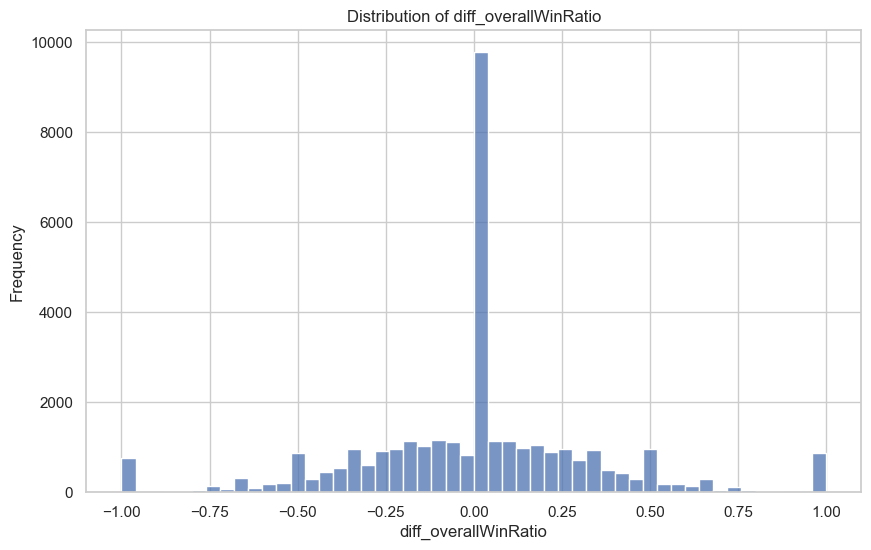

In [37]:
# Function to calculate the overall win ratio for a player with time discount factor
def calculate_overall_win_ratio(player_id, player_data, start_date, end_date, discount_period, discount_factor):
    win_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        result = row['p1_won'] if player_id == row['p1_id'] else 1 - row['p1_won']
        win_sum += weight * result
        total_weight += weight

    win_ratio = win_sum / total_weight if total_weight else 0.50
        
    return (win_ratio, total_weight) if not player_data.empty else (None, None)

# Function to calculate overall win ratio difference for a match
def calculate_overall_win_ratio_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])  
    
    p1_win_ratio, p1_total_weight = calculate_overall_win_ratio(row['p1_id'], p1_data, start_date, end_date, discount_period, discount_factor)
    p2_win_ratio, p2_total_weight = calculate_overall_win_ratio(row['p2_id'], p2_data, start_date, end_date, discount_period, discount_factor)

    # # For debugging
    # display(p1_data[['p1_id', 'p2_id', 'p1_won', 'match_date']].sort_values(by=['p1_id', 'match_date']))
    # p1_data[['p1_id', 'p2_id', 'p1_won', 'match_date']].sort_values(by=['p1_id', 'match_date']).to_clipboard()
    # display(p2_data[['p1_id', 'p2_id', 'p1_won', 'match_date']].sort_values(by=['p2_id', 'match_date']))
    # p2_data[['p1_id', 'p2_id', 'p1_won', 'match_date']].sort_values(by=['p2_id', 'match_date']).to_clipboard()
    # print(p1_win_ratio, p2_win_ratio)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_win_ratio, p2_win_ratio, uncertainty_threshold)

# Apply the overall win ratio difference calculation to the dataframe
df['diff_overallWinRatio'] = df.apply(lambda row: calculate_overall_win_ratio_difference(
    row, time_frame=365, common_opponents=True, discount_period=365, discount_factor=0.95, uncertainty_threshold=5), axis=1)

show_favorite_win_rate('diff_overallWinRatio')
plot_histogram(df['diff_overallWinRatio'], bins=50, kde=False)

# # For debugging
# calculate_overall_win_ratio_difference(
#     row=df[df['match_id'] == '2022-0605-0300'].iloc[0], 
#     time_frame=365*20, 
#     common_opponents=True, 
#     discount_period=365, 
#     discount_factor=1, 
#     uncertainty_threshold=1
# )


##### Head to Head Win Ratio Difference #####

In [38]:
%%script echo skipped
### GRID SEARCH ###
# Function to calculate head-to-head win percentage for a specific player with time discount factor
def calculate_head_to_head(player_id, player_data, start_date, end_date, discount_period, discount_factor):
    win_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        result = row['p1_won'] if player_id == row['p1_id'] else 1 - row['p1_won']
        win_sum += weight * result
        total_weight += weight

    win_ratio = win_sum / total_weight if total_weight else 0.50

    return (win_ratio, total_weight) if not player_data.empty else (None, None)

# Function to calculate the difference in head-to-head win percentages for a match
def calculate_head_to_head_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    h2h_data = pd.merge(p1_data, p2_data, how='inner', on=['match_id'])
    h2h_data.rename(columns={col: col.rstrip('_x') for col in h2h_data.columns if col.endswith('_x')}, inplace=True)

    p1_win_ratio, p1_total_weight = calculate_head_to_head(row['p1_id'], h2h_data, start_date, end_date, discount_period, discount_factor)
    p2_win_ratio, p2_total_weight = calculate_head_to_head(row['p2_id'], h2h_data, start_date, end_date, discount_period, discount_factor)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_win_ratio, p2_win_ratio, uncertainty_threshold)

# Define ranges for the parameters
time_frame_range = [365*20]
common_opponents_range = [False]
discount_period_range = [180]
discount_factor_range = [0.90]
uncertainty_threshold_range = [100]

# Create a DataFrame to store results
results = []

# Iterate over all combinations of parameters
total_iterations = len(time_frame_range) * len(common_opponents_range) * len(discount_period_range) * len(discount_factor_range) * len(uncertainty_threshold_range)
current_iteration = 1

for time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold in product(
        time_frame_range, common_opponents_range, discount_period_range, discount_factor_range, uncertainty_threshold_range):
    
    # Calculate the feature with the current set of parameters
    df['diff_h2hWinRatio'] = df.apply(lambda row: calculate_head_to_head_difference(
        row, 
        time_frame=time_frame, 
        common_opponents=common_opponents, 
        discount_period=discount_period, 
        discount_factor=discount_factor, 
        uncertainty_threshold=uncertainty_threshold), 
        axis=1)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Prepare the feature
    X = df[['diff_h2hWinRatio']].fillna(0)

    # Scale the feature to [0, 1]
    X_scaled = scaler.fit_transform(X)

    # Prepare the target
    y = df['p1_won']

    # Calculate chi-square score for the feature
    chi2_score, p_values = chi2(X_scaled, y)

    # Append the results
    results.append({
        'common_opponents': common_opponents,
        'discount_period': discount_period,
        'discount_factor': discount_factor,
        'time_frame': time_frame,
        'uncertainty_threshold': uncertainty_threshold,
        'Chi2_Score': chi2_score[0],
        'P_Value': p_values[0]
    })

    # Drop the column to prepare for the next iteration
    df.drop('diff_h2hWinRatio', axis=1, inplace=True)

    # Display the results
    clear_output(wait=True)
    results_df = pd.DataFrame(results)
    sorted_results = results_df.sort_values(by='Chi2_Score', ascending=False)
    display(sorted_results.head(200))

    # Print progress update
    print(f"Completed iteration {current_iteration}/{total_iterations} at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    current_iteration += 1

# Export sorted results to a CSV file inside the '_fe' folder
sorted_results.to_csv('_fe/diff_h2hWinRatio.csv', index=False)


skipped


,Win Counts,Total Counts,Favorite's Win Rate
diff_h2hWinRatio,,,
0.00,12525,19124,65.49
1.00,3486,5205,66.97
-1.00,3514,5164,68.05
-0.33,3,6,50.00
0.33,4,6,66.67
...,...,...,...
-0.19,0,1,0.00
-0.19,0,1,0.00
-0.19,0,1,0.00


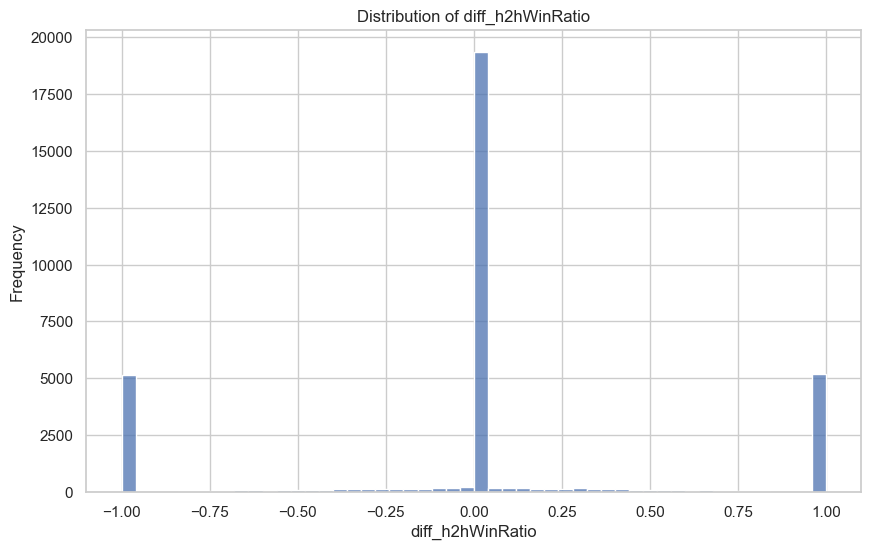

In [39]:
# Function to calculate head-to-head win percentage for a specific player with time discount factor
def calculate_head_to_head(player_id, player_data, start_date, end_date, discount_period, discount_factor):
    win_sum = 0
    total_weight = 0
    for _, row in player_data.iterrows():
        weight = calculate_weight(row['match_date'], end_date, discount_period, discount_factor)
        result = row['p1_won'] if player_id == row['p1_id'] else 1 - row['p1_won']
        win_sum += weight * result
        total_weight += weight

    win_ratio = win_sum / total_weight if total_weight else 0.50

    return (win_ratio, total_weight) if not player_data.empty else (None, None)

# Function to calculate the difference in head-to-head win percentages for a match
def calculate_head_to_head_difference(row, time_frame, common_opponents, discount_period, discount_factor, uncertainty_threshold):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    if common_opponents:
        p1_data, p2_data = filter_by_common_opponents(p1_data, p2_data, row['p1_id'], row['p2_id'])

    h2h_data = pd.merge(p1_data, p2_data, how='inner', on=['match_id'])
    h2h_data.rename(columns={col: col.rstrip('_x') for col in h2h_data.columns if col.endswith('_x')}, inplace=True)

    p1_win_ratio, p1_total_weight = calculate_head_to_head(row['p1_id'], h2h_data, start_date, end_date, discount_period, discount_factor)
    p2_win_ratio, p2_total_weight = calculate_head_to_head(row['p2_id'], h2h_data, start_date, end_date, discount_period, discount_factor)

    # # For debugging
    # display(h2h_data[['p1_id', 'p2_id', 'p1_won', 'match_date']].sort_values(by=['match_date']))
    # h2h_data[['p1_id', 'p2_id', 'p1_won', 'match_date']].sort_values(by=['match_date']).to_clipboard()
    # print(p1_win_ratio, p2_win_ratio)
    # print(p1_total_weight, p2_total_weight)

    return calculate_uncertainty_and_difference(p1_total_weight, p2_total_weight, p1_win_ratio, p2_win_ratio, uncertainty_threshold)

# Apply the difference in head-to-head win percentages calculation to the dataframe
df['diff_h2hWinRatio'] = df.apply(lambda row: calculate_head_to_head_difference(
    row, time_frame=365*20, common_opponents=False, discount_period=180, discount_factor=0.9, uncertainty_threshold=100), axis=1)

show_favorite_win_rate('diff_h2hWinRatio')
plot_histogram(df['diff_h2hWinRatio'], bins=50, kde=False)

# # For debugging
# calculate_head_to_head_difference(
#     row=df[df['match_id'] == '2022-1536-0296'].iloc[0], 
#     time_frame=365*20, 
#     common_opponents=False, 
#     discount_period=365, 
#     discount_factor=1, 
#     uncertainty_threshold=1
# )


##### Match Win-Loss Streak Difference #####

In [40]:
%%script echo skipped
### GRID SEARCH ###
# Function to calculate the win-loss streak for a player
def calculate_win_loss_streak(player_id, player_data, end_date):
    player_data = player_data.sort_values(by='match_date', ascending=False)
    streak = 0
    for _, row in player_data.iterrows():
        if row['match_date'] > end_date:
            continue
        won = row['p1_won'] if player_id == row['p1_id'] else 1 - row['p1_won']
        if streak == 0:
            streak = 1 if won else -1
        elif (streak > 0 and won) or (streak < 0 and not won):
            streak += 1 if won else -1
        else:
            break
    return streak

# Function to calculate the difference in win-loss streaks for a match
def calculate_win_loss_streak_difference(row, time_frame):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    p1_streak = calculate_win_loss_streak(row['p1_id'], p1_data, end_date)
    p2_streak = calculate_win_loss_streak(row['p2_id'], p2_data, end_date)

    return p1_streak - p2_streak

# Define a range of time_frame values to test
time_frame_range = [15, 30, 60, 90, 180, 365, 365*2, 365*3, 365*5, 365*20]

# Create a DataFrame to store results
results = []

# Iterate over all combinations of parameters
total_iterations = len(time_frame_range)
current_iteration = 1

for time_frame in time_frame_range:
    # Calculate the feature with the current set of parameters 
    df['diff_winLossStreak'] = df.apply(lambda row: calculate_win_loss_streak_difference(row, time_frame), axis=1)

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Prepare the feature
    X = df[['diff_winLossStreak']].fillna(0)

    # Scale the feature to [0, 1]
    X_scaled = scaler.fit_transform(X)

    # Prepare the target
    y = df['p1_won']

    # Calculate chi-square score for the feature
    chi2_score, p_values = chi2(X_scaled, y)

    # Append the results
    results.append({
        'time_frame': time_frame,
        'Chi2_Score': chi2_score[0],
        'P_Value': p_values[0]
    })

    # Drop the column to prepare for the next iteration
    df.drop('diff_winLossStreak', axis=1, inplace=True)

    # Display the results
    clear_output(wait=True)
    results_df = pd.DataFrame(results)
    sorted_results = results_df.sort_values(by='Chi2_Score', ascending=False)
    display(sorted_results.head(200))

    # Print progress update
    print(f"Completed iteration {current_iteration}/{total_iterations} at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    current_iteration += 1

# Export sorted results to a CSV file inside the '_fe' folder
sorted_results.to_csv('_fe/diff_winLossStreak.csv', index=False)


skipped


,Win Counts,Total Counts,Favorite's Win Rate
diff_winLossStreak,,,
0,8711,13443,64.80
1,2594,4009,64.70
-1,2608,3988,65.40
-2,1829,2730,67.00
2,1766,2665,66.27
...,...,...,...
-28,0,1,0.00
-22,0,1,0.00
-24,1,1,100.00


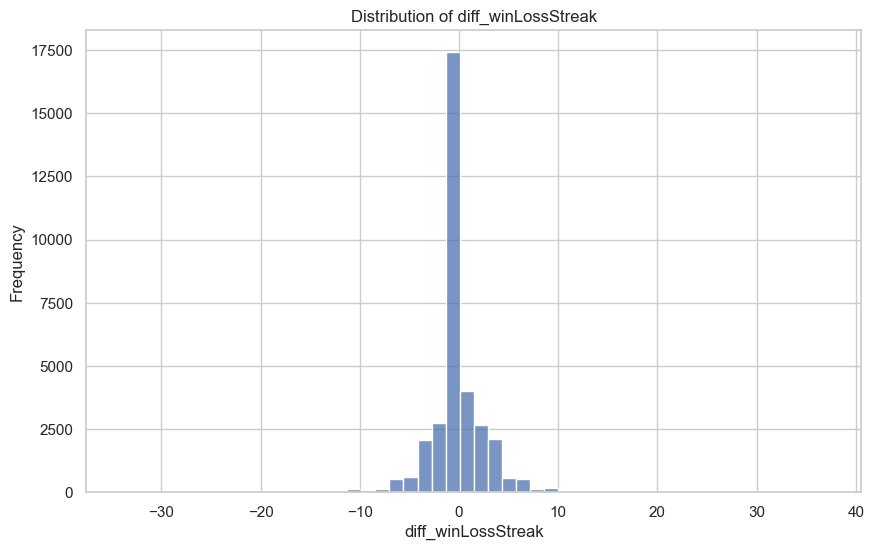

In [41]:
# Function to calculate the win-loss streak for a player
def calculate_win_loss_streak(player_id, player_data, end_date):
    player_data = player_data.sort_values(by='match_date', ascending=False)
    streak = 0
    for _, row in player_data.iterrows():
        if row['match_date'] > end_date:
            continue
        won = row['p1_won'] if player_id == row['p1_id'] else 1 - row['p1_won']
        if streak == 0:
            streak = 1 if won else -1
        elif (streak > 0 and won) or (streak < 0 and not won):
            streak += 1 if won else -1
        else:
            break
    return streak

# Function to calculate the difference in win-loss streaks for a match
def calculate_win_loss_streak_difference(row, time_frame):
    start_date = row['match_date'] - timedelta(days=time_frame)
    end_date = row['match_date']

    p1_data = get_player_data(row['p1_id'], start_date, end_date, row.name)
    p2_data = get_player_data(row['p2_id'], start_date, end_date, row.name)

    p1_streak = calculate_win_loss_streak(row['p1_id'], p1_data, end_date)
    p2_streak = calculate_win_loss_streak(row['p2_id'], p2_data, end_date)

    # # For debugging
    # display(p1_data[['p1_id', 'p2_id', 'p1_won', 'match_date']].sort_values(by=['p1_id', 'match_date']))
    # p1_data[['p1_id', 'p2_id', 'p1_won', 'match_date']].sort_values(by=['p1_id', 'match_date']).to_clipboard()
    # display(p2_data[['p1_id', 'p2_id', 'p1_won', 'match_date']].sort_values(by=['p2_id', 'match_date']))
    # p2_data[['p1_id', 'p2_id', 'p1_won', 'match_date']].sort_values(by=['p2_id', 'match_date']).to_clipboard()
    # print(p1_streak, p2_streak)

    return p1_streak - p2_streak

# Apply the win-loss streak difference calculation to the dataframe
df['diff_winLossStreak'] = df.apply(lambda row: calculate_win_loss_streak_difference(row, time_frame=365*20), axis=1)

# Visualize and analyze the new feature
show_favorite_win_rate('diff_winLossStreak')
plot_histogram(df['diff_winLossStreak'], bins=50, kde=False)

# # For debugging
# calculate_win_loss_streak_difference(
#     row=df[df['match_id'] == '2022-0605-0300'].iloc[0], 
#     time_frame=365*20
# )


In [42]:
# Export dataset to excel
df.to_excel('_data/_matches_list_v5.xlsx', index=False)